# Visualizing VSPO clipper data from Holodex



## Set up

- imports
- load Japanese font 
- `rcParams`
- `matplotlib` and `seaborn` settings

In [1]:
import pandas as pd 
import numpy as np 

from pathlib import Path 

import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns 

DATADIR = Path.cwd().parent / 'data/vspo_clippers'
OUTDIR = DATADIR.parents[1] / 'output'

In [2]:
import matplotlib.font_manager as fm

plt.style.use('default')
sns.set_style('whitegrid')

font_path = r"C:/Users/delbe/AppData/Local/Programs/Python/Python310/Lib/site-packages/matplotlib/mpl-data/fonts/ttf/arial-unicode-ms.ttf"
fm.fontManager.addfont(font_path)
cjk_font = fm.FontProperties(fname=font_path, size=13)

sns.set(font=cjk_font.get_family())
sns.set_style('whitegrid', {"font.sans-serif":[cjk_font.get_name()]})

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = cjk_font.get_name()  

In [3]:
rcParams.update({
    'figure.dpi' : 300,
    'ytick.labelsize' : 8,
    'xtick.labelsize' : 9, 
    'figure.constrained_layout.use' : True,
    'savefig.bbox' : 'tight',
    'axes.linewidth' : 1.2, 
    'axes.formatter.limits' : (-3, 3),
    'axes.grid' : False, 
    'axes.titlepad' : 14
})

In [4]:
def savefig(fig: plt.Figure, filename: str, dir=OUTDIR, **kwargs) -> None:
    fig.savefig(dir / f"{filename}.png", **kwargs)

### Convenience functions for plotting

In [5]:
from datetime import datetime
from msilib.text import tables
import regex as re 

NON_ALPHABET_PAT = re.compile(r"[^\w\_\:\!\.]*")

def style_ticklabels(ax: plt.Axes, axis: str, names: list[str], append='', remove_non_alphabet=True, repl='', **kwargs) -> None:
    if axis == 'x':
        labs = ax.xaxis.get_ticklabels()
    else:
        labs = ax.yaxis.get_ticklabels()
    
    for i, lab in enumerate(labs):
        t = lab.get_text()
        
        if t in names:

            if remove_non_alphabet:
                t = NON_ALPHABET_PAT.sub(repl, t)

            lab.set_text(t + append)
            lab.set(**kwargs)

    ax.set_yticklabels(labs)
    return 

def dt2mdy(dt: datetime) -> str:
    return datetime.strftime(dt, r"%b %d, %Y")

def get_title(dates: pd.Series) -> str:
    r = (dates.min(), dates.max())      # range 
    first, last = map(dt2mdy, r)
    ndays = (r[1] - r[0]).\
        total_seconds() // 86400
    
    return f"{first} ~ {last} ({ndays:.0f} days)"

def basic_barplot(
    x: list, y: list, 
    xlabel: str, ylabel: str, title: str, 
    xlab_kw: dict={},
    barplot_kw: dict=dict(palette='rocket'), 
    ylab_kw: dict=dict(rotation=0, loc='top', labelpad=-200),
    title_kw: dict = dict(x=-0.4, pad=22, fontsize=12, ha='left'),
    ) -> tuple[plt.Figure, plt.Axes]:
    
    fig, ax = plt.subplots(figsize=(4, 11))
    sns.barplot(x=x, y=y, ax=ax, **barplot_kw)

    ax.set_title(title, **title_kw)
    ax.set_xlabel(xlabel, **xlab_kw)
    ax.set_ylabel(ylabel, **ylab_kw)

    ax.tick_params(axis='y', labelsize=8)
    ax.xaxis.set_label_position('top')

    return fig, ax 


## Import data

- Import data
- Methods to access/index data 
- Methods to compute certain statistics

In [6]:
# functions for `pd.DataFrame.agg`
_quant25 = lambda x: np.quantile(x, 0.25)
_quant75 = lambda x: np.quantile(x, 0.75)

def get_agg_stats(df: pd.DataFrame, col: str=None, by: str=None) -> pd.DataFrame:
    new_cols = ['mean', 'median', '25pctl', '75pctl', 'min', 'max', 'std', 'sum', 'count']
    funcs = ['mean', np.median, _quant25, _quant75, 'min', 'max', np.std, 'sum', 'count']

    if isinstance(df, pd.Series) or df.shape[1] < 2:
        fs = funcs[:2] + funcs[4:]
        ns = new_cols[:2] + new_cols[4:]
        ns.extend(new_cols[2:4])

        _stats = df.agg(fs).tolist()
        _stats.extend(df.quantile([0.25, 0.75]))
        df_stats = pd.Series(_stats, index=ns)

    else:
        df_stats = df.groupby(by).agg(funcs)
        df_stats.columns = new_cols
    
    return df_stats.sort_values('count', ascending=False) 

def gby_fn(df: pd.DataFrame, by: str, fn: object) -> pd.DataFrame:
    return df.groupby(by).agg(fn)

def date_slice(df: pd.DataFrame, dt_col='Date', start: datetime=None, end: datetime=None) -> pd.DataFrame:
    dt = df.loc[:, dt_col]
    start = start if start else dt.min()
    end = end if end else dt.max()
    
    return df.loc[(dt < end) & (dt > start), :]

def sep_by_unit(df: pd.DataFrame, dt_col='Date', unit='month') -> dict[str, pd.DataFrame]:
    
    dt_props = df.loc[:, dt_col].dt
    if unit == 'month':
        units = dt_props.month_name()
    elif unit == 'year':
        units = dt_props.year 
    elif unit in ['week', 'weekofyear']:
        units = dt_props.isocalendar().week
    elif unit == 'dayofweek':
        units = dt_props.day_of_week
    elif unit == 'day':
        units = dt_props.day 
    elif unit == 'dayofyear':
        units = dt_props.day_of_year
    else:
        raise NotImplemented()

    uq = units.unique()
    return {u : df.loc[units == u, :] for u in uq}

def stats_by_unit(df: pd.DataFrame, dt_col='Date', unit='month', col=None, by=None) -> dict[str, pd.DataFrame]:
    return {
        dt_val : get_agg_stats(df_dt, col=col, by=by)
        for dt_val, df_dt in 
        sep_by_unit(df, dt_col=dt_col, unit=unit).items()
    }



In [7]:
data = pd.read_csv(DATADIR / 'merged.csv', index_col=0, header=0, encoding='utf-8', parse_dates=['Date'])
data.Channel = data.Channel.str.strip()
DT_PROPS = data['Date'].dt
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3458 entries, 599 to 1057
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      3458 non-null   datetime64[ns]
 1   Duration  3458 non-null   int64         
 2   Channel   3458 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 108.1+ KB


In [8]:
total_stats = get_agg_stats(data, 'Duration', by='Channel')
monthly_stats_dict = stats_by_unit(data, by='Channel', col='Duration')


## Visualizations

1. For EN vs. JP clippers, count and duration: sum, boxplot
2. July - October: count, duration + cumulative sum, running average
   1. Total
   2. Stratified by EN vs JP clippers

### Convenience functions for plotting

In [9]:
import regex as re 

def secs2dhms(secs: int) -> str:
    units = [86400, 3600, 60]
    dhms = [] 
    
    for u in units:
        n = secs // u 
        secs -= u*n 
        dhms.append(n)

    return f"{dhms[0]} days, {dhms[1]} hours, {dhms[2]} minutes, {round(secs, 0)} seconds"

JAP_PAT = re.compile(r"[a-zA-Z]+")

def get_EN_JP_channels(df: pd.DataFrame, col='Channel') -> tuple[np.ndarray]:
    clippers = df[col].unique()
    clippers.sort()

    en_clippers = np.array(['Daruma English Clip', 'Ene Chan',
        'Galaxy VTuber Translations', 'Holo EYE',
        'Hololive are Idols [TL]', 'IonXepH', 'Laplus Clip / Hololive',
        'Leveret Translations', 'Nel', 'Oboretai Writing ch.',
        'Otaku-kun subs', 'Pebo-kun TL ぺぼ', 'R Subs', 'Renri',
        'Rezado-subs', 'Sakura [Vtuber切り抜き翻訳]', 'ShiroiRika',
        'Slice of Vspo', 'Sobbers Clipper', 'Towa Clips', 'TungT',
        'Ush Order Subs', 'V LOVE CLIP English', 
        'Virtualyzm', 'Vspo! Clips', 'Vspo!【Eng Clip】', 'Vtube Tengoku',
        'Vtuber resistance-Eng sub', 'What I Like Subs',
        'X-ray VSPO!【Eng Sub】', 'Yudha 【Ruuzami】', 'Yuri Shizu',
        'Yuri Shizu -Sub Channel-', 'Zoro Zaki [ Clypto ]', 'kanaway',
        'kuzuha blood pack', 'oyama clips', 'rinrinz', 'yd_',
    ])

    jp_clippers = clippers[~np.isin(clippers, en_clippers)]

    print(f"Number of channels:\nJP: {jp_clippers.size}, EN: {en_clippers.size}")
    return en_clippers, jp_clippers

def get_EN_JP_clips(df: pd.DataFrame, en_clippers: list[str], col='Channel') -> tuple[pd.DataFrame]:
    isEN = df[col].isin(en_clippers)
    en_clips = df.loc[isEN, :]
    jp_clips = df.loc[~isEN, :]
    return en_clips, jp_clips

def get_EN_JP_data_dict(df_list: list[pd.DataFrame], langs: list[str]) -> dict[str, pd.DataFrame]:
    return {lang : df for lang, df in zip(langs, df_list)}

def total_duration(clips: list[pd.DataFrame], col='Duration', as_hrs=True) -> list[float]:
    return list(
        map(
            lambda x: x/3600, 
            (df[col].sum() for df in clips)
        )
    )

func2dict = lambda d, func: {k : func(v) for k, v in d.items()}

def annotate_bars(ax: plt.Axes, xvals: list, yvals: list, labels=None, orient='v', fmt="%.0f", label_suffix: list=None, **kwargs) -> None:
    
    coords = [xvals, yvals]
    
    for i, vals in enumerate(coords):
        if not isinstance(vals[0], (float, int, np.int32, np.int64, np.float32, np.float64)):
            coords[i] = range(len(vals))
    
    if labels is None:
        labels = yvals if orient in ['v', 'vertical'] else xvals
    if label_suffix is None or isinstance(label_suffix, str):
        label_suffix = ['']*len(labels)
        
    if isinstance(labels[0], str):
        tmplt = lambda i: labels[i] + label_suffix[i]
    else:
        tmplt = lambda i: (fmt % labels[i]) + f"{label_suffix[i]}"

    for i, (x, y) in enumerate(zip(*coords)):
        ax.text(
            x, y, 
            tmplt(i), 
            transform=ax.transData,
            **kwargs
        )


In [10]:
TITLE = get_title(data['Date'])
def add_title(fig: plt.Figure, title=TITLE, fontsize=10, fontweight='bold', fontfamily='Verdana', x=0, y=1.1, ha='left', va='bottom') -> None:
    fig.suptitle(
        title,
        x=x, y=y, ha=ha, va=va, 
        fontsize=fontsize, 
        fontweight=fontweight,
        fontfamily=fontfamily
    )

In [11]:
langs = ['EN', 'JP']
clippers = {lang : df for lang, df in zip(langs, get_EN_JP_channels(data))}
clips = {lang : df for lang, df in zip(langs, get_EN_JP_clips(data, clippers['EN']))}

Number of channels:
JP: 70, EN: 39


### Stratified by channel language

In [104]:
def get_pval_stars(pval: float, sym: str) -> tuple[str, float]:
    for i, p in enumerate([0.001, 0.01, 0.05]):
        if pval < p: 
            return f"{sym * (3-i)},  p < {p}"
    
    return None

def draw_pval(ax: plt.Axes, xpos: list[float], ymax: float, pval: float, frac=0.03, sym=r"$\star$", color='r', fontsize=9, **kwargs) -> None:
    
    ylims = ax.get_ylim()
    ypad = frac*(ylims[1] - ylims[0])

    ypos = [ymax + ypad] * 2
    ax.plot(xpos, ypos, c=color, **kwargs)

    if pval <= 0.05: 
        txt = get_pval_stars(pval, sym)
    else: 
        txt = r"n.s., p $\approx$ " + f"{pval:.3f}"
    
    ax.text(
        np.mean(xpos), ymax + ypad, txt, 
        fontsize=fontsize, 
        color=color,
        ha='center', 
        va='bottom',
        transform=ax.transData
    )

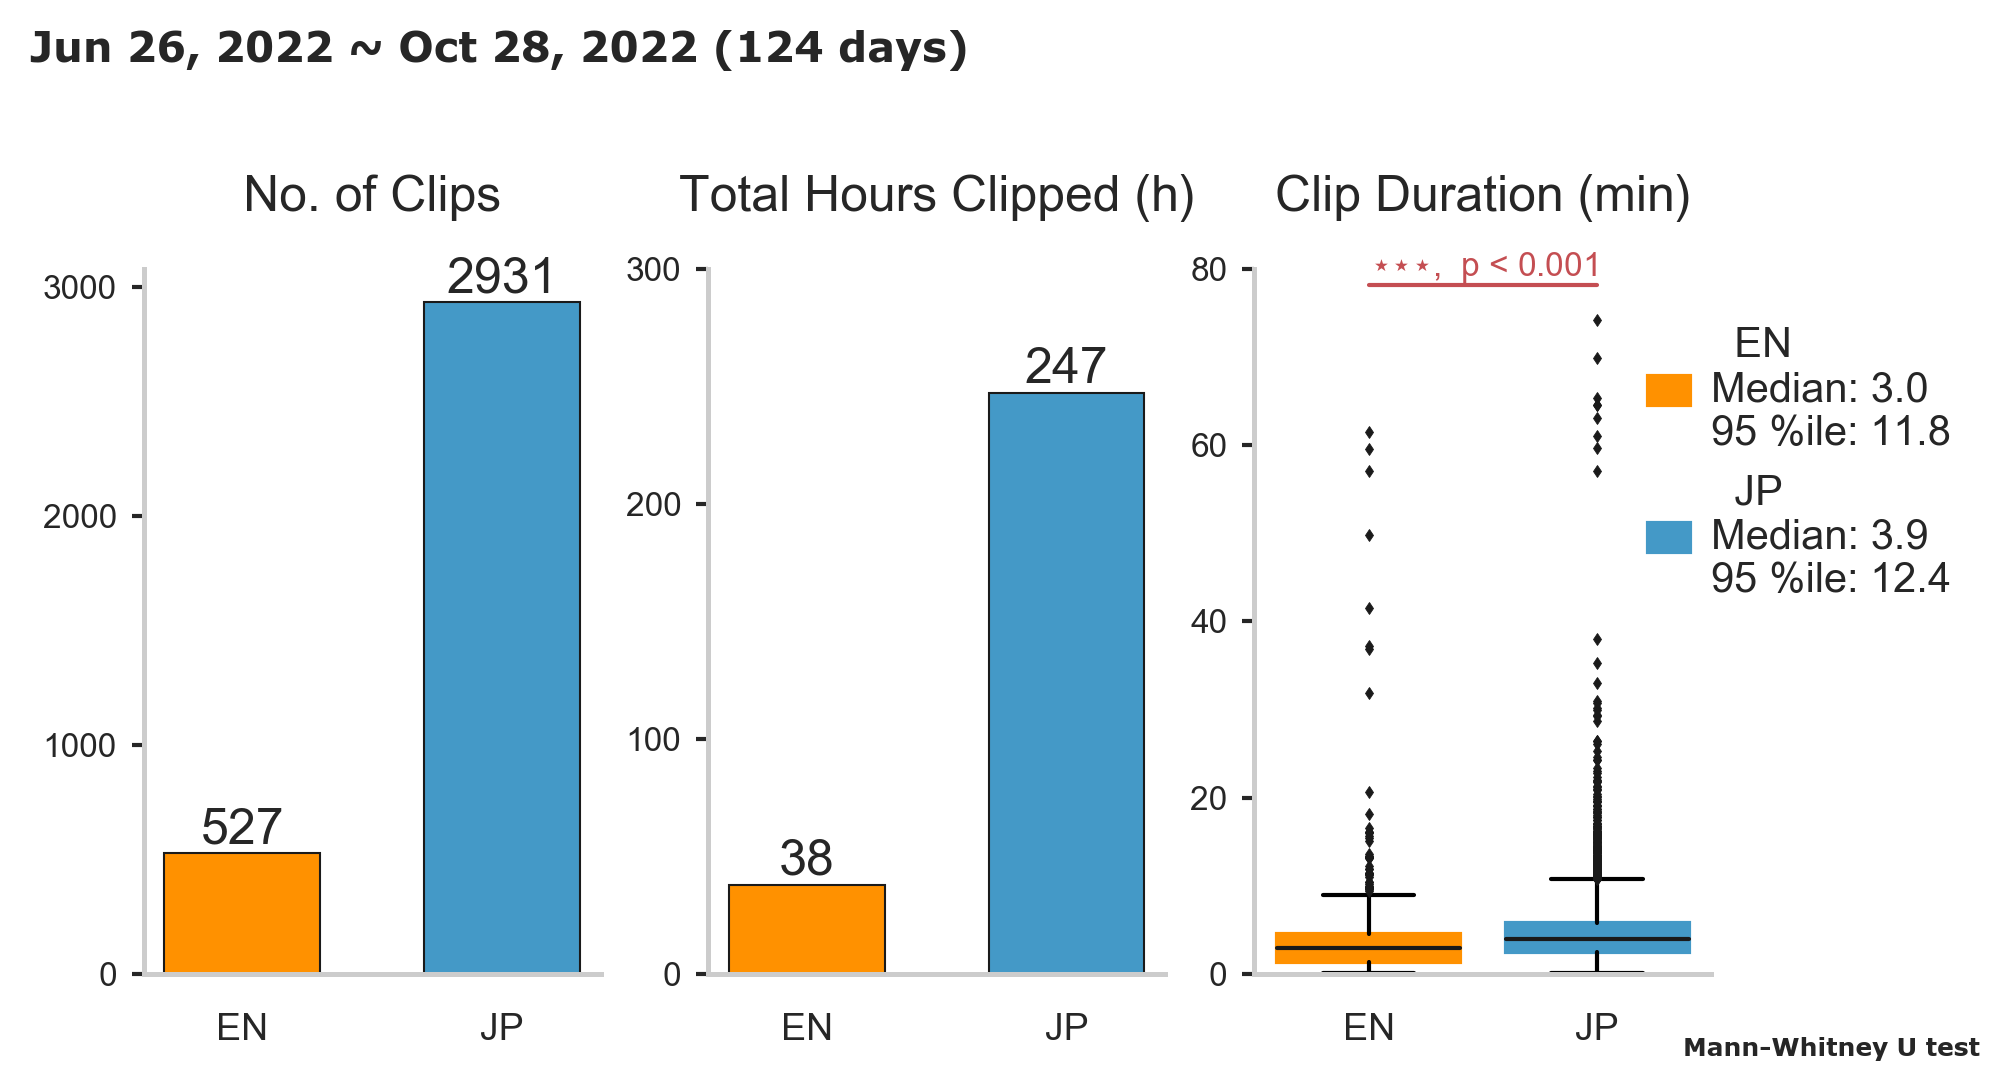

In [13]:
from scipy.stats import mannwhitneyu

fig, ax = plt.subplots(1, 3, figsize=(6.5,  3))

add_title(fig)
colors = ['#ff9100', '#4499c7']
kw = dict(
    width=0.6,
    color = colors,
    edgecolor = 'k',
    linewidth = 0.5
)

y = [v.shape[0] for v in clips.values()]
ax[0].bar(x=langs, height=y, **kw)
annotate_bars(ax[0], langs, y, ha='center', va='bottom')
ax[0].ticklabel_format(axis='y', scilimits=(2, 4))
ax[0].set_title("No. of Clips")

y = [v['Duration'].sum()/3600 for v in clips.values()]
ax[1].bar(x = langs, height = y, **kw)

annotate_bars(ax[1], langs, y, ha='center', label_suffix='h', va='bottom')
ax[1].set_title("Total Hours Clipped (h)")
ax[1].set_ylim((0, 300))

y = [v['Duration']/60 for v in clips.values()]
bp = ax[2].boxplot(
    y,
    sym='d',
    widths=0.8,
    labels=clips.keys(),
    flierprops=dict(mec='k', ls='none', mew=0.2, mfc='k', ms=2),
    medianprops=dict(color='k'),
    patch_artist=True,
)

ax[2].set_title('Clip Duration (min)')
ax[2].set_ylim((0, 80))
for box, clr in zip(bp['boxes'], colors):
    plt.setp(box, facecolor=clr, color=clr)

box_lab_fmt = lambda x, i: f"Median: {np.median(x[i]):.1f}\n95 %ile: {np.quantile(x[i], 0.95):.1f}"
box_labs = [f"  {lang}\n" + box_lab_fmt(y, i) for i, lang in enumerate(langs)]
ax[2].legend(
    bp['boxes'], box_labs, 
    loc='upper left', bbox_to_anchor=[0.78, 0.97], 
    fontsize=10, handlelength=1, handletextpad=0.5, frameon=False)

for a in ax:
    sns.despine(ax=a)
    a.locator_params(axis='y', nbins=5)
    a.tick_params(axis='y', length=3, width=1, left=True)

_, pval = mannwhitneyu(clips['EN'].Duration, clips['JP'].Duration, alternative='two-sided')
draw_pval(ax[2], [1, 2], data.Duration.max()/60, pval, fontsize=8, lw=1, frac=0.05)

fig.text(1, 0, "Mann-Whitney U test", fontsize=6, fontweight='semibold', fontfamily='Verdana', ha='right', va='bottom')

savefig(fig, 'total_number_hours_byLang')

### Stratified by channel, but not time

In [14]:
def plot_top25_hbars(
    df_ch: pd.DataFrame, 
    title=TITLE, 
    palette='mako', 
    unit='h',
    fig: plt.Figure=None, 
    axs: list[plt.Axes]=None, 
    names_to_style: list[str]=clippers['EN'], 
    style_kwargs = dict(
        color='r', 
        fontweight='bold', 
        append=u"\u24BA", 
        remove_non_alphabet=False)
    ) -> tuple[plt.Figure, plt.Axes]:

    if axs is None: 
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    add_title(fig, title=title)

    for i in range(2):
        df_i = df_ch.iloc[:,i].sort_values(ascending=False)
        
        y = df_i.iloc[:25]
        sns.barplot(x=y.values, y=y.index, palette=palette, ax=axs[i])
        # axs[i].boxplot(df_i, positions=[-1], vert=False, sym='d', showfliers=False, patch_artist=True, widths=(1,))

        # axs[i].set_ylabel('Channel', rotation=0, loc='top', labelpad=-100)
        axs[i].tick_params(axis='y', labelsize=7.7, length=3, width=1, left=True)
        sns.despine(ax=axs[i])
        axs[i].set_ylabel(None)

        if names_to_style is None:
            continue 
    
        if style_kwargs:
            style_ticklabels(
                axs[i], 
                axis='y', 
                names=names_to_style, 
                **style_kwargs
            )

        inds = np.arange(y.shape[0], dtype=int)
        inds = inds[np.isin(y.index, names_to_style)]
        y_en = y.iloc[inds]
        
        axs[i].grid(True, axis='x', alpha=0.5, lw=1)
        annotate_bars(
            axs[i], y_en + 0.05 * y.max(), 
            inds, 
            labels=[f"#{j}" for j in inds+1],
            label_suffix=[
                f' ({v:.1f}{unit})' if isinstance(v, float) 
                else f' ({v:d})' for v in y_en
            ],
            orient='h', 
            ha='left', 
            va='center',
            fontsize=8.5,
            fontweight='semibold',
            zorder=2
        )

        # _25pctile = np.mean(df_i.values <= df_i.iat[24]) * 100
        # axs[i].text(1.02, 0, f"{_25pctile:.0f} %ile", ha='left', va='center', fontsize=9, transform=axs[i].transAxes)

    axs[0].set_xlabel(f'Total Clipped Duration ({unit})', fontsize=9)
    axs[1].set_xlabel('No. of Clips', fontsize=9)

    return fig, ax 

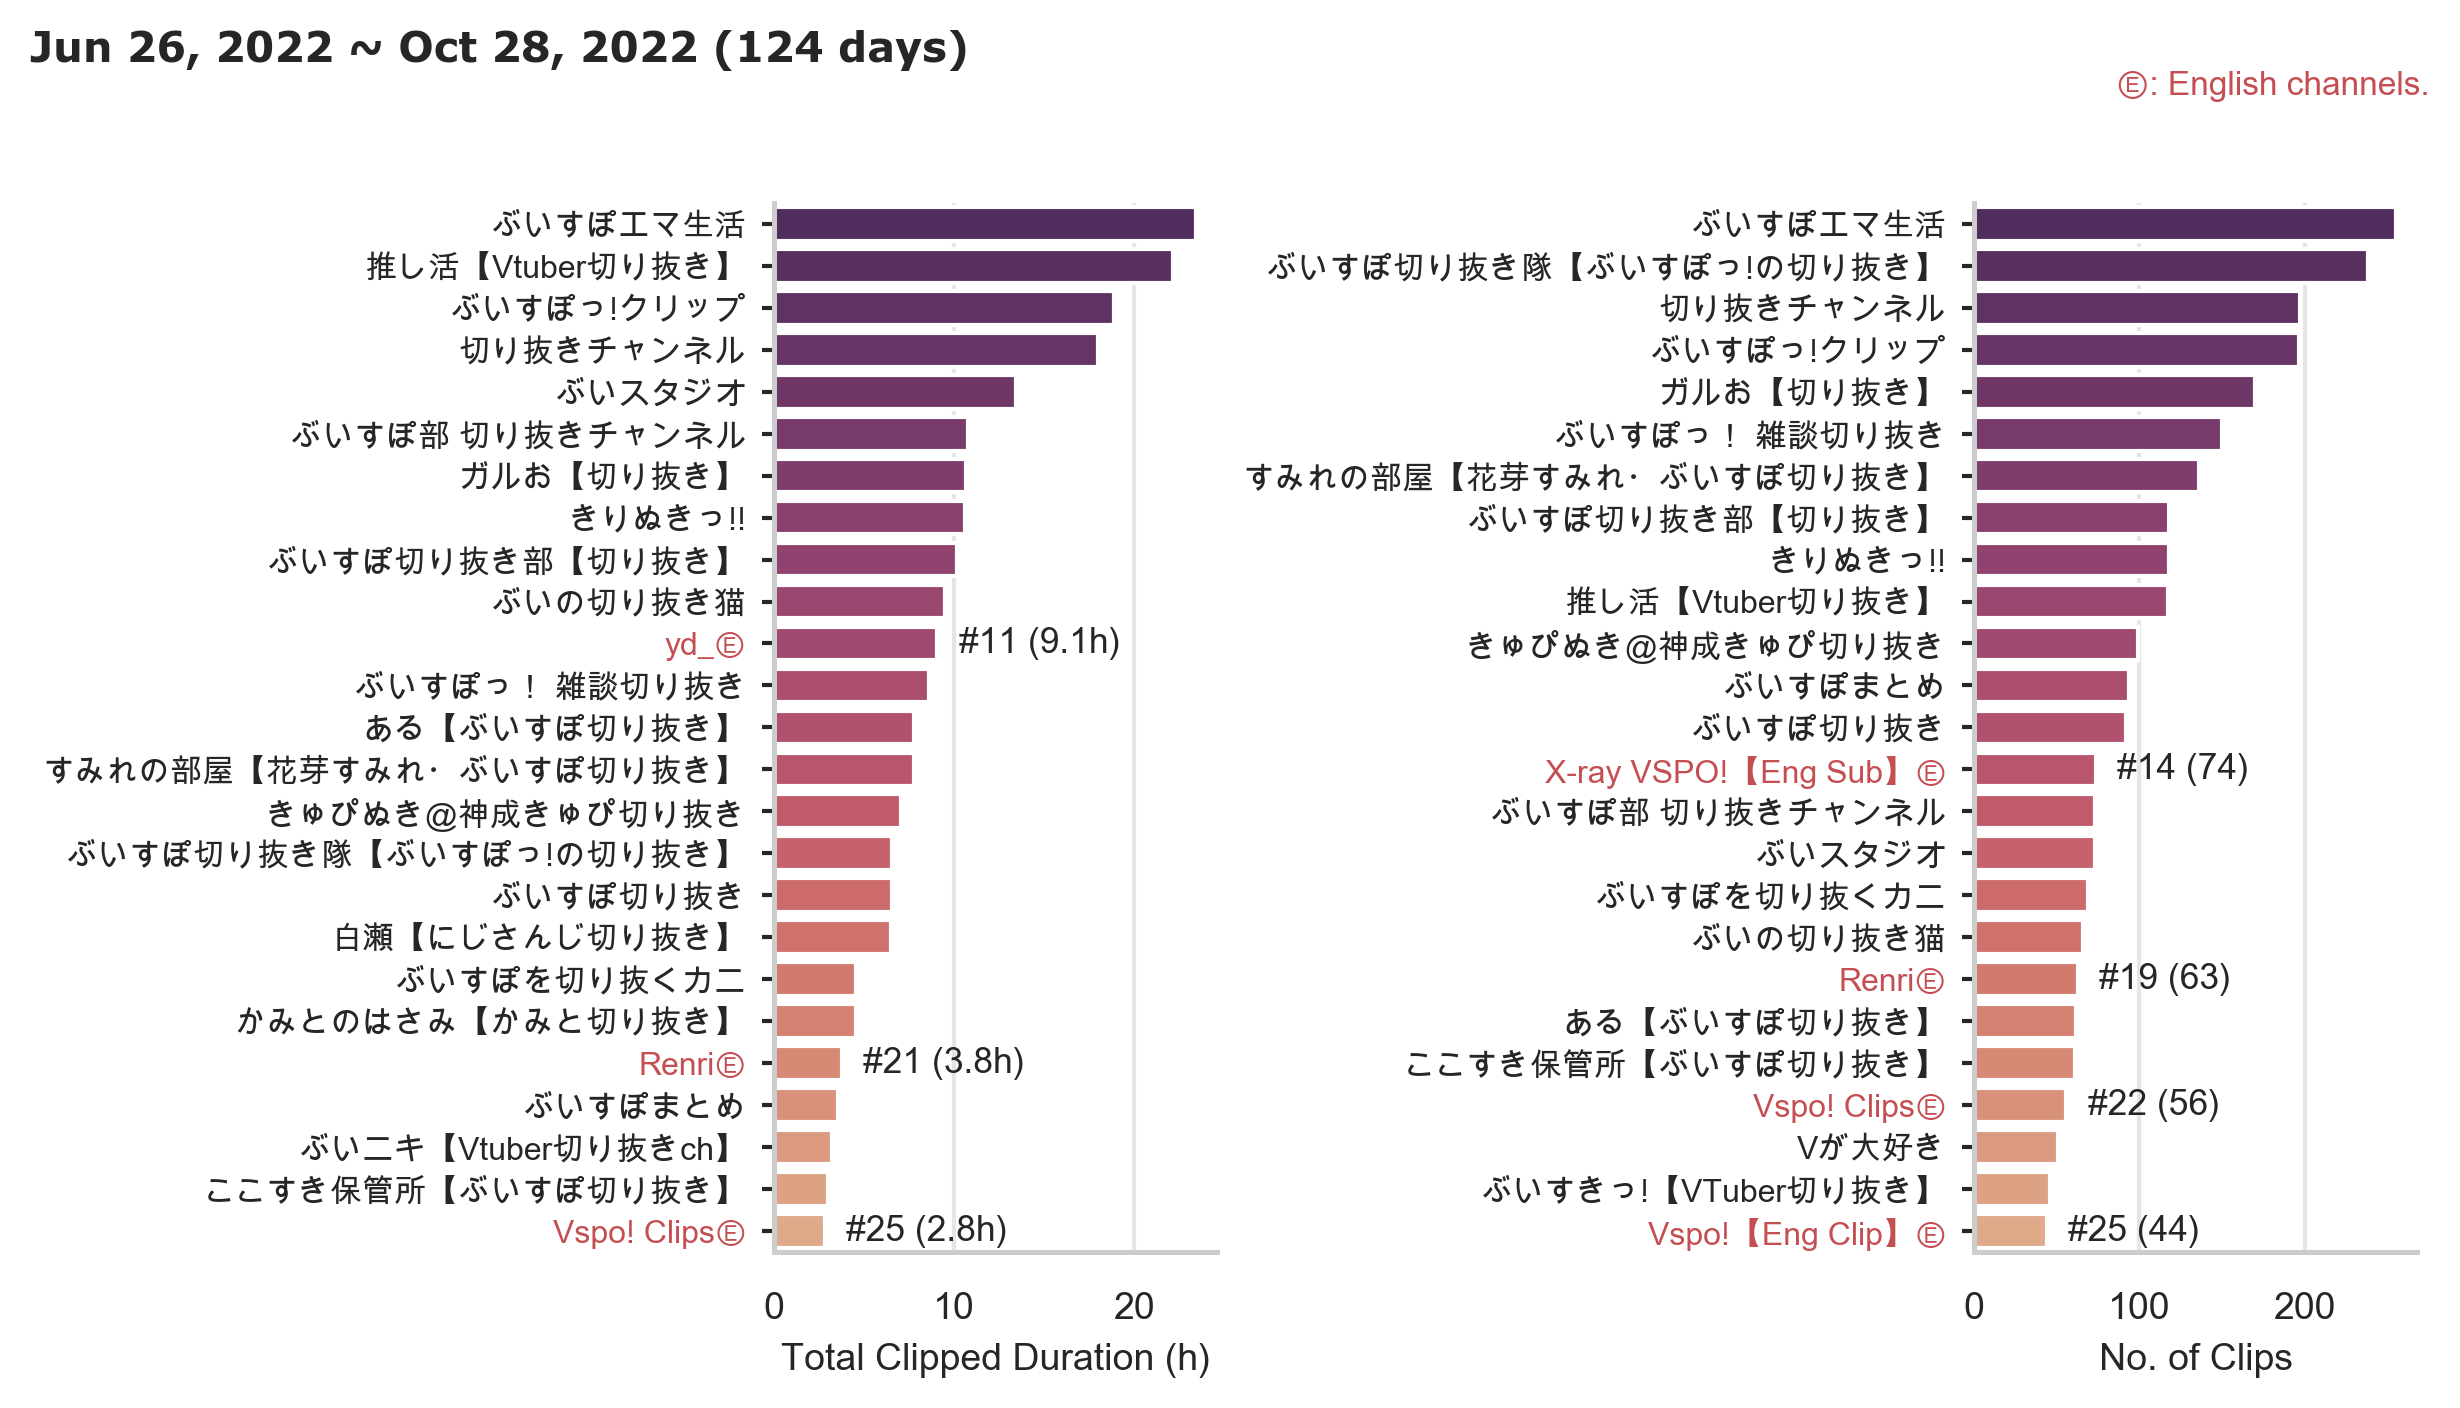

In [15]:
df_ch = data.loc[:, ['Channel', 'Duration']].groupby('Channel').\
    agg(['sum', 'count'])

df_ch.iloc[:,0] /= 3600

fig, _ = plot_top25_hbars(df_ch, palette='flare_r')
fig.text(
    1, 1.1, u"\u24BA: English channels.", 
    color='r', fontsize=8, 
    fontweight='bold', 
    ha='right', va='top', 
    transform=fig.transFigure
)

savefig(fig, 'top25_total-hours-count_124d_JP+EN')

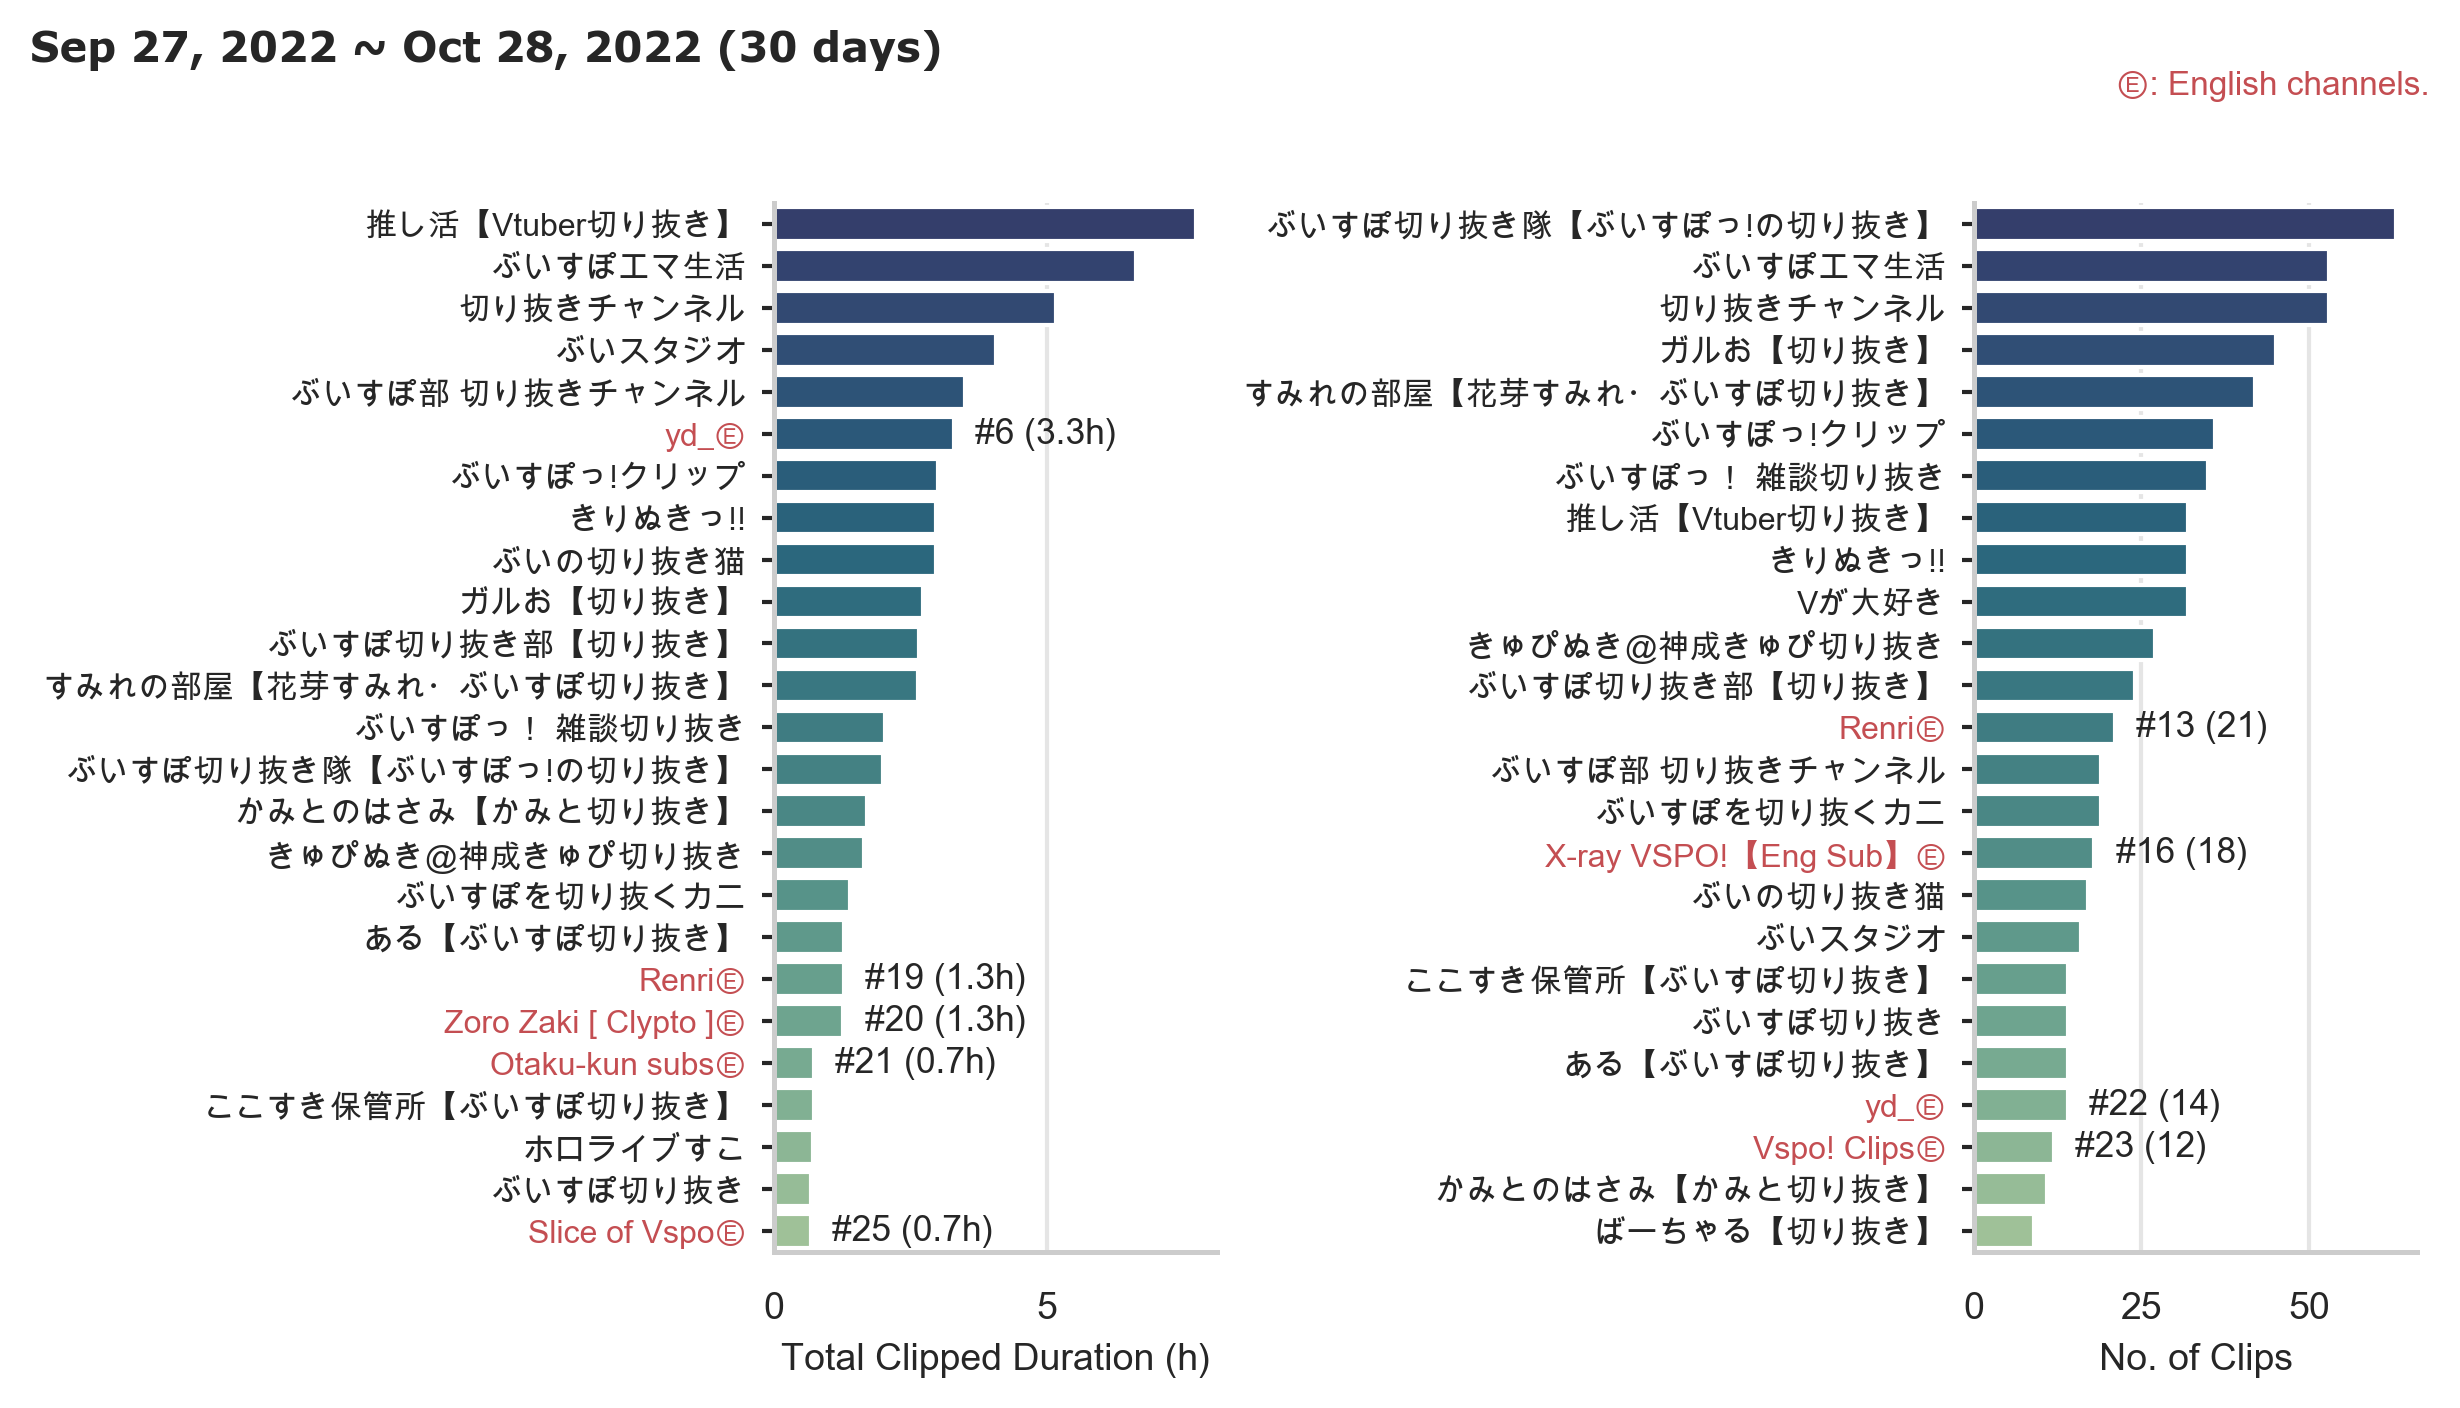

In [16]:
from datetime import timedelta

ts = data.Date.max() - timedelta(days=31)
title_oct = get_title(data.loc[data.Date > ts, 'Date'])

df_ch = data.loc[data.Date > ts, ['Channel', 'Duration']].\
    groupby('Channel').\
    agg(['sum', 'count'])

df_ch.iloc[:,0] /= 3600

fig, _ = plot_top25_hbars(df_ch, title=title_oct, palette='crest_r')
fig.text(
    1, 1.1, u"\u24BA: English channels.", 
    color='r', fontsize=8, 
    fontweight='bold', 
    ha='right', va='top', 
    transform=fig.transFigure
)

savefig(fig, 'top25_total-hours-count_30d_JP+EN')

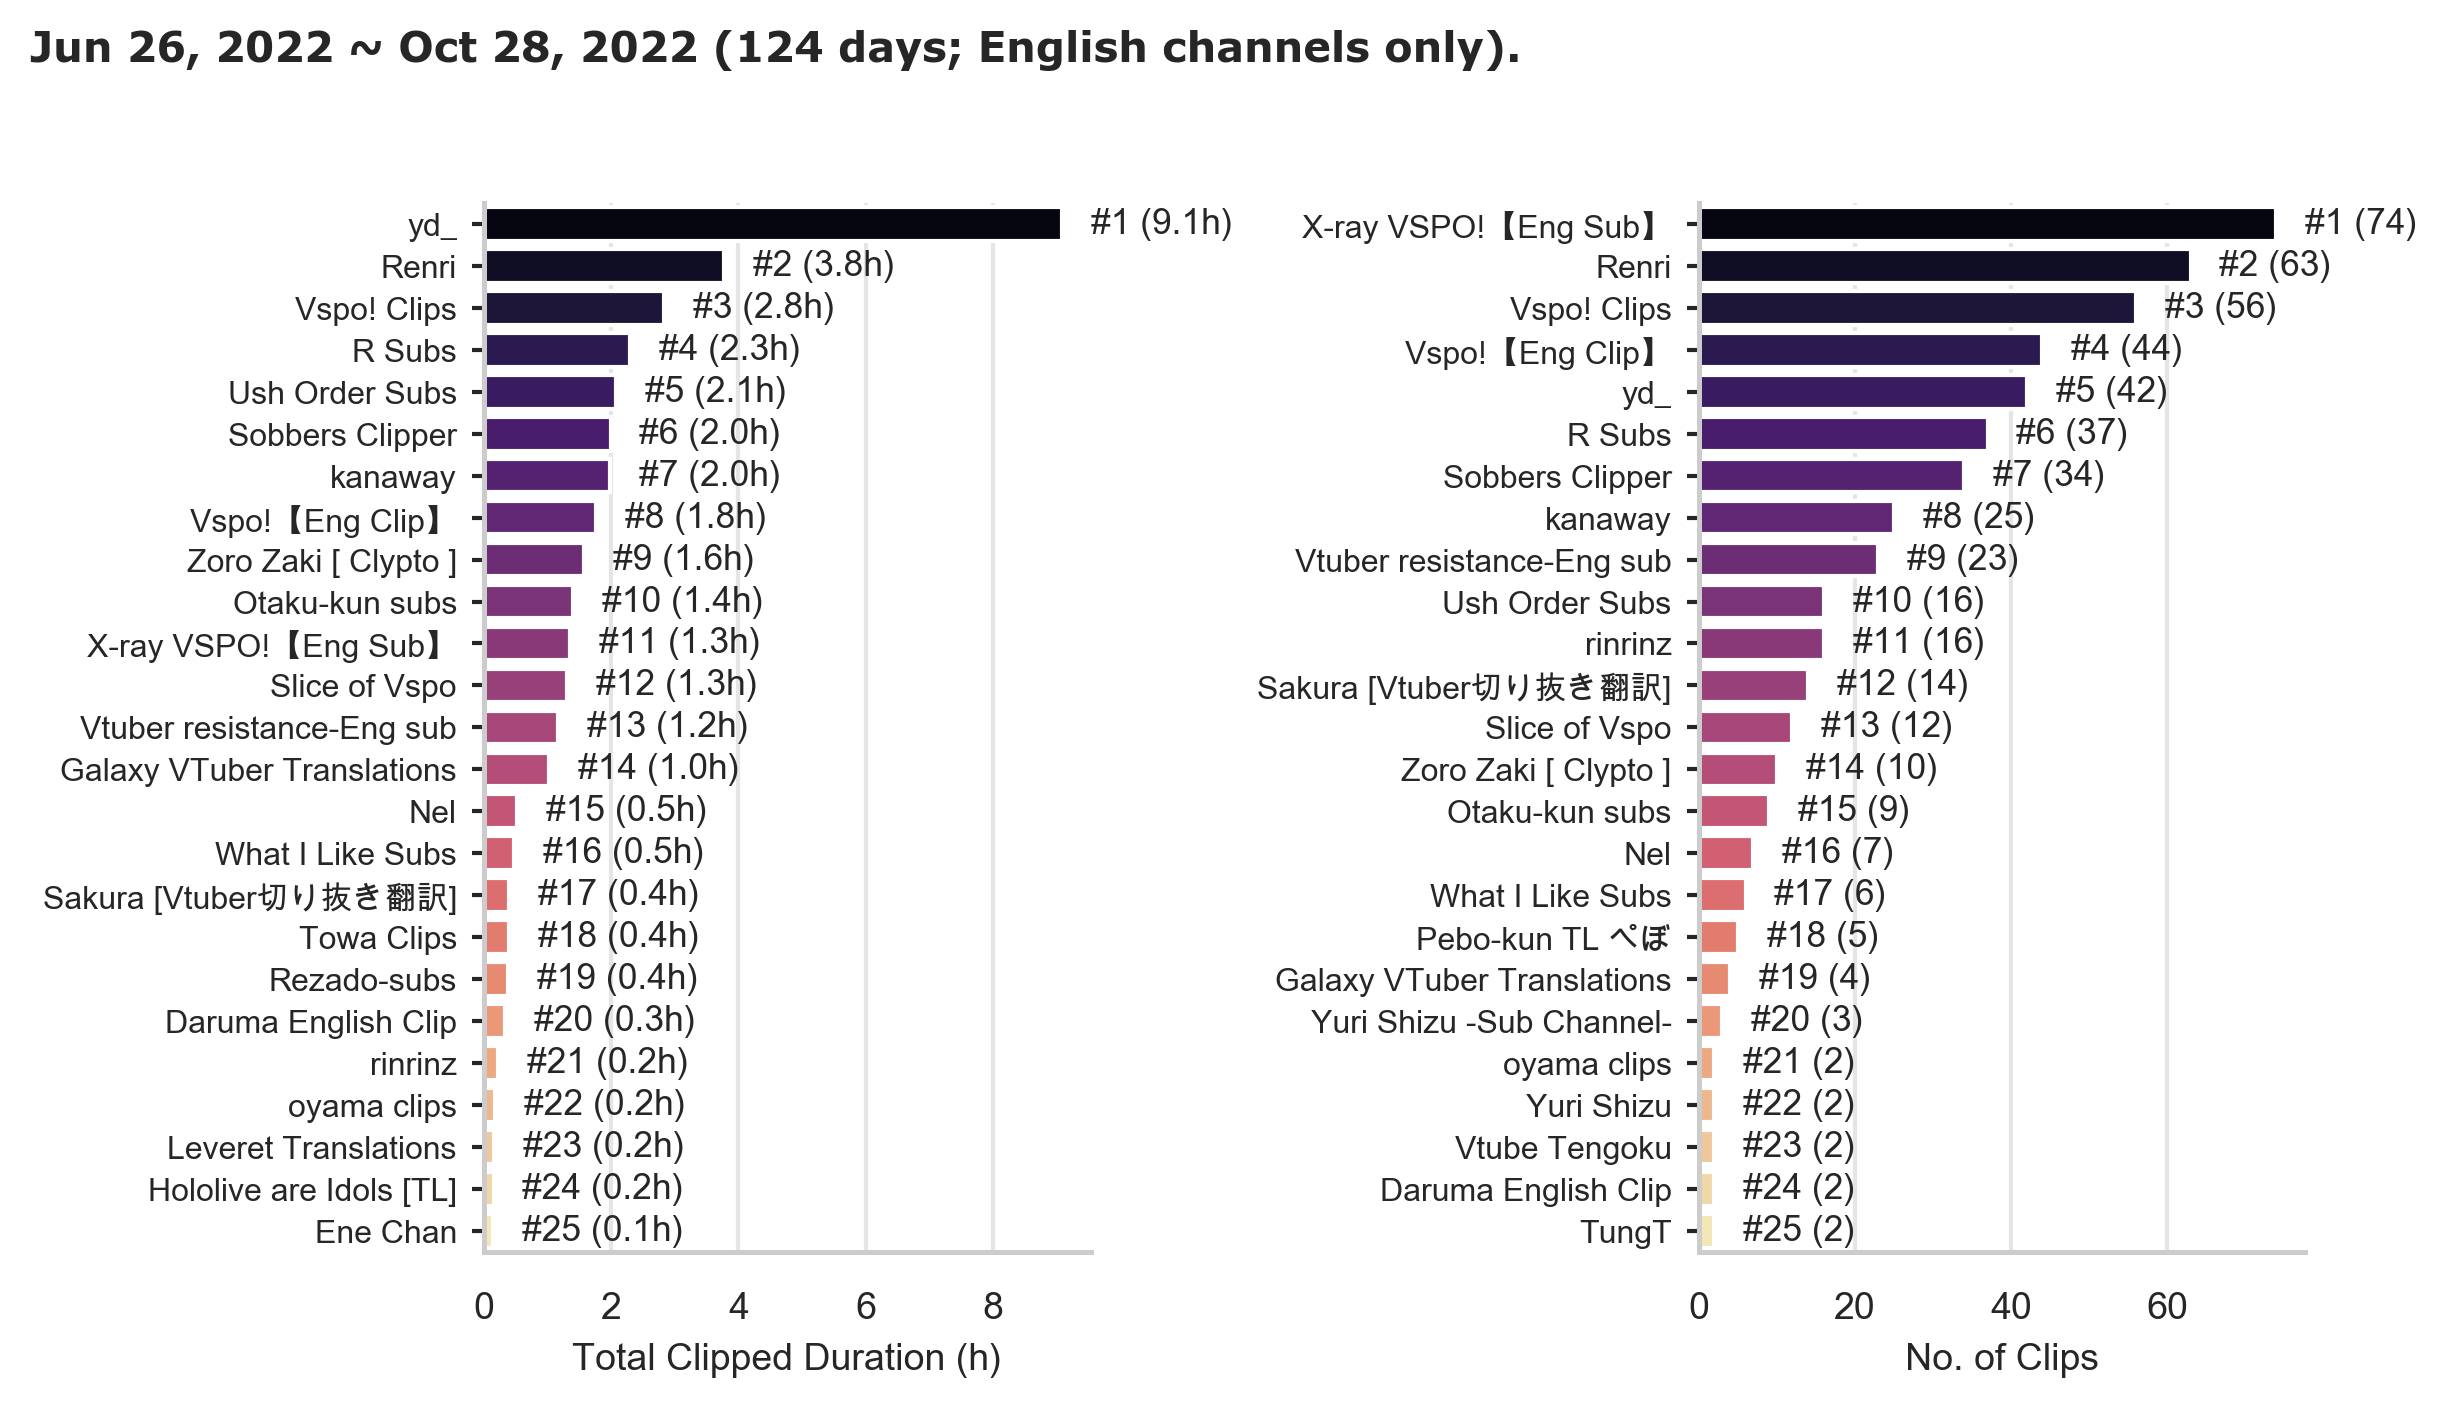

In [17]:
df_ch = clips['EN'].\
    groupby('Channel').\
    agg(['sum', 'count'])

df_ch.iloc[:,0] /= 3600

fig, _ = plot_top25_hbars(
    df_ch, title=TITLE[:-1] + "; English channels only).",
    palette='magma',
    style_kwargs=dict()
)

savefig(fig, 'top25_total-hours-count_124d_EN')

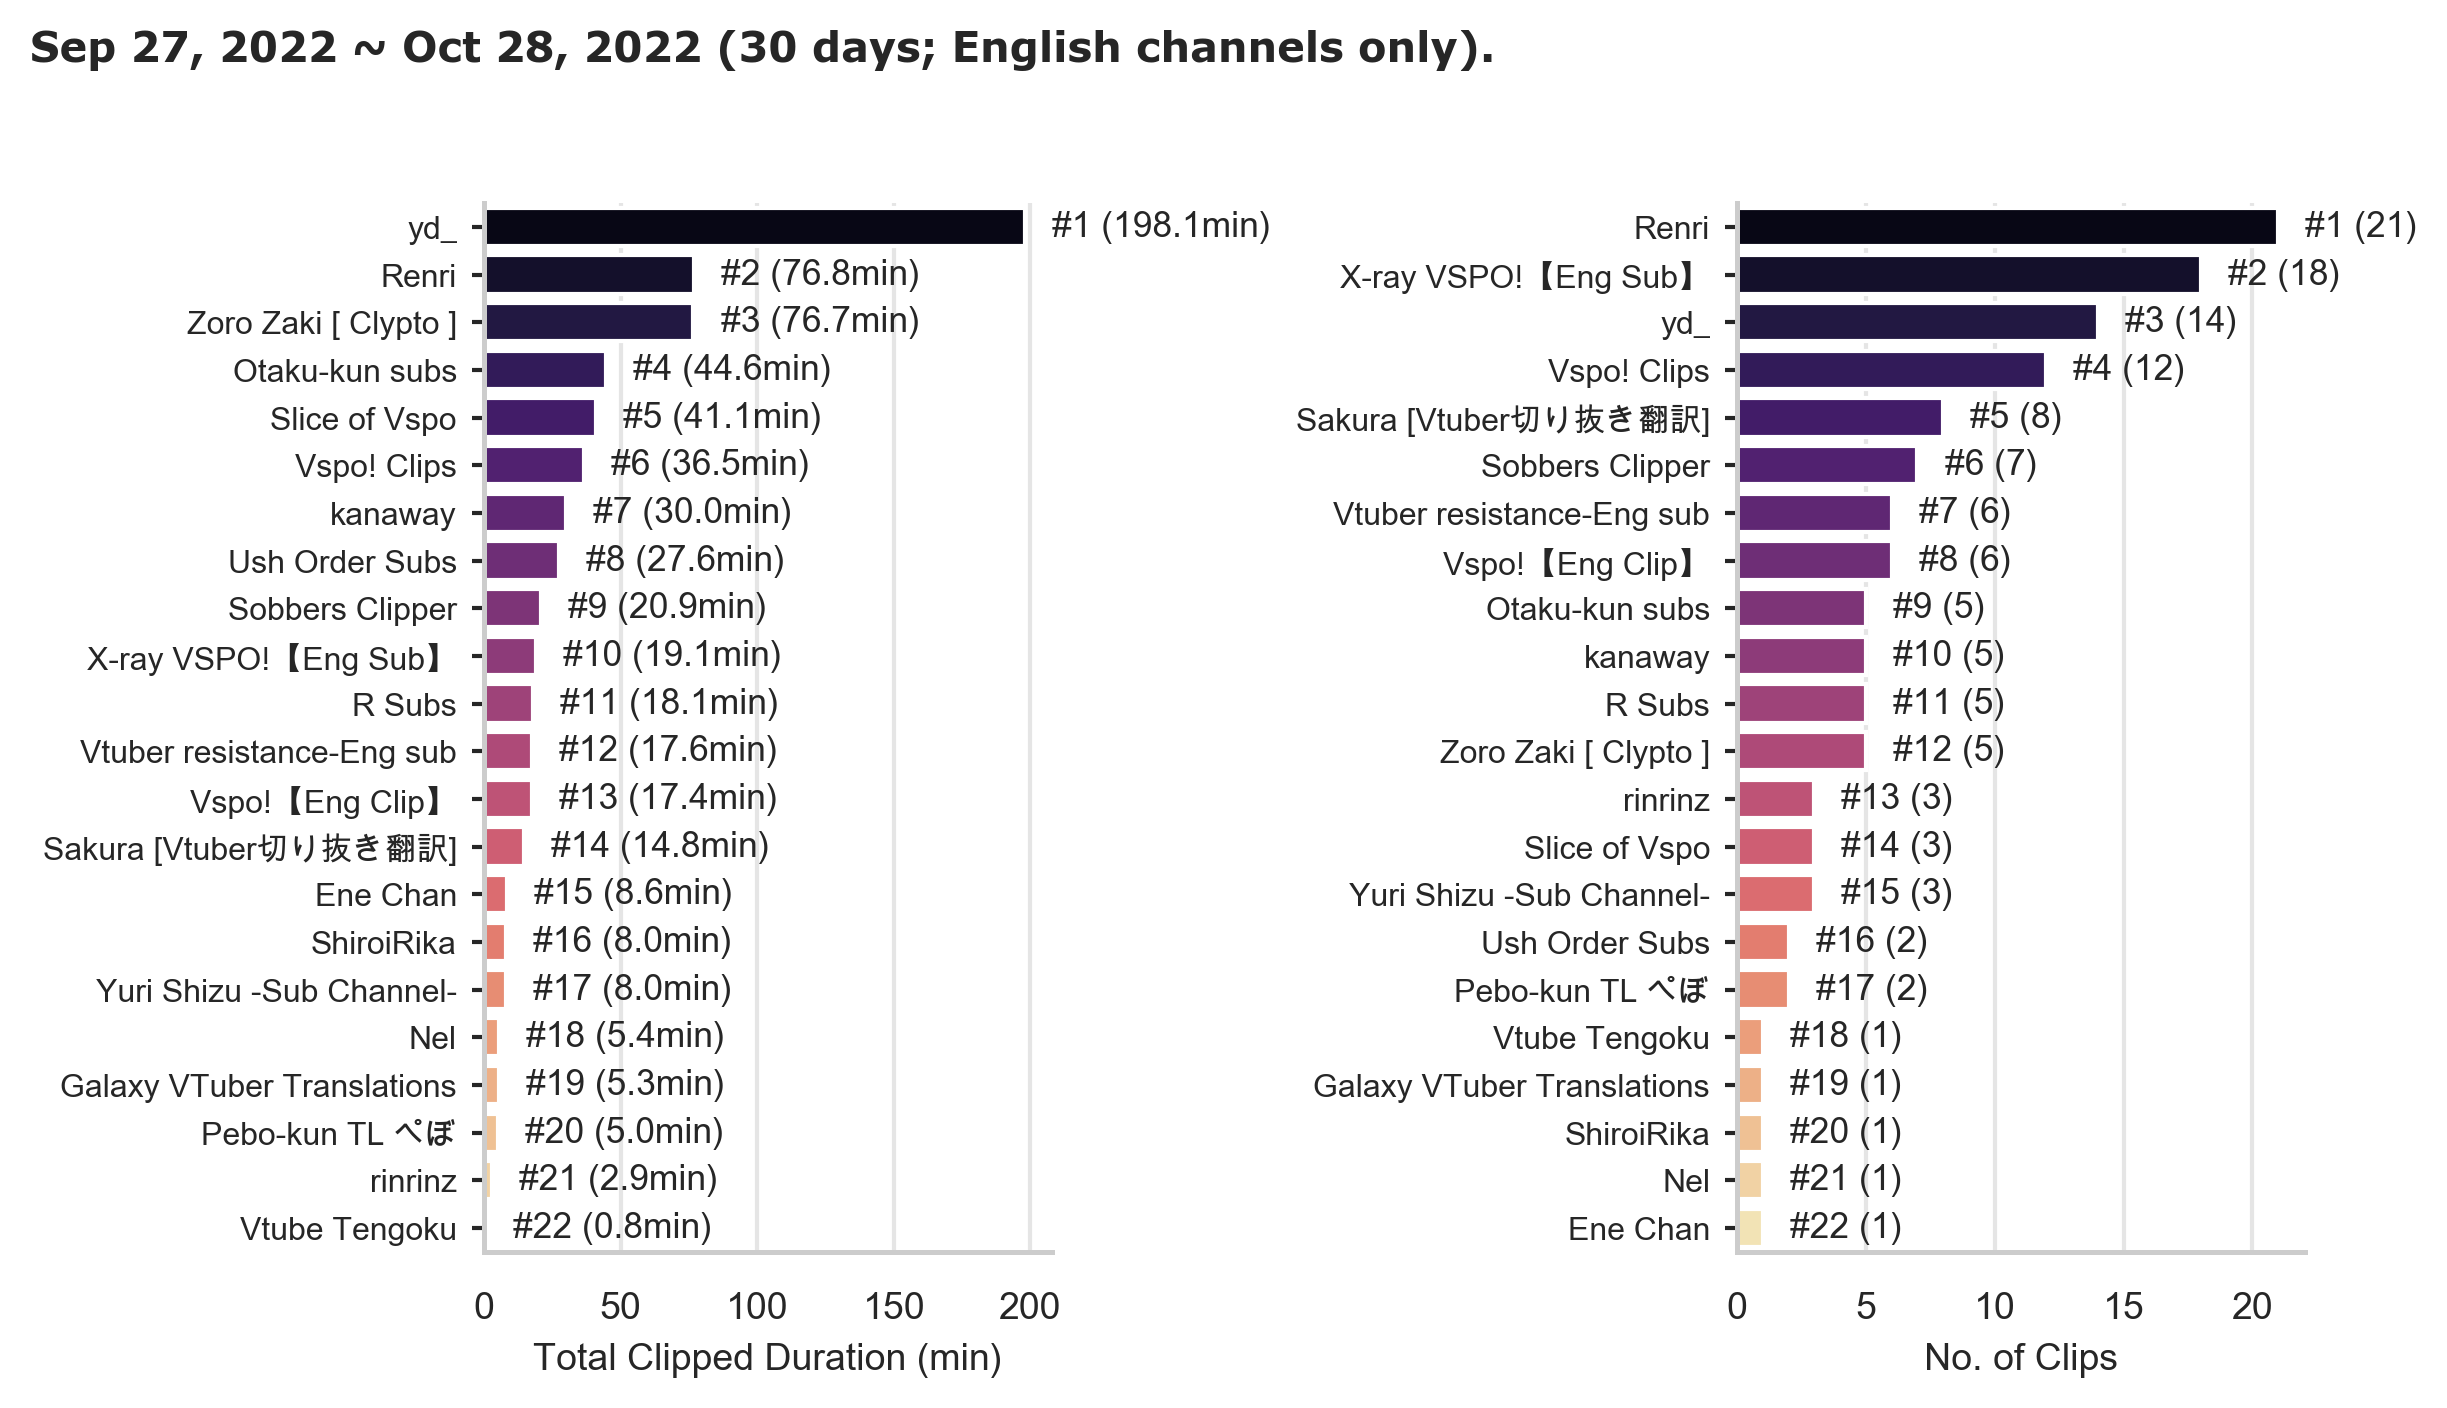

In [18]:
df_ch = clips['EN'].loc[clips['EN'].Date > ts, :].\
    groupby('Channel').\
    agg(['sum', 'count'])

df_ch.iloc[:,0] /= 60

fig, _ = plot_top25_hbars(
    df_ch, 
    unit='min',
    palette='magma',
    style_kwargs=dict(),
    title=title_oct[:-1] + "; English channels only).",
)

savefig(fig, 'top25_total-hours-count_30d_EN')

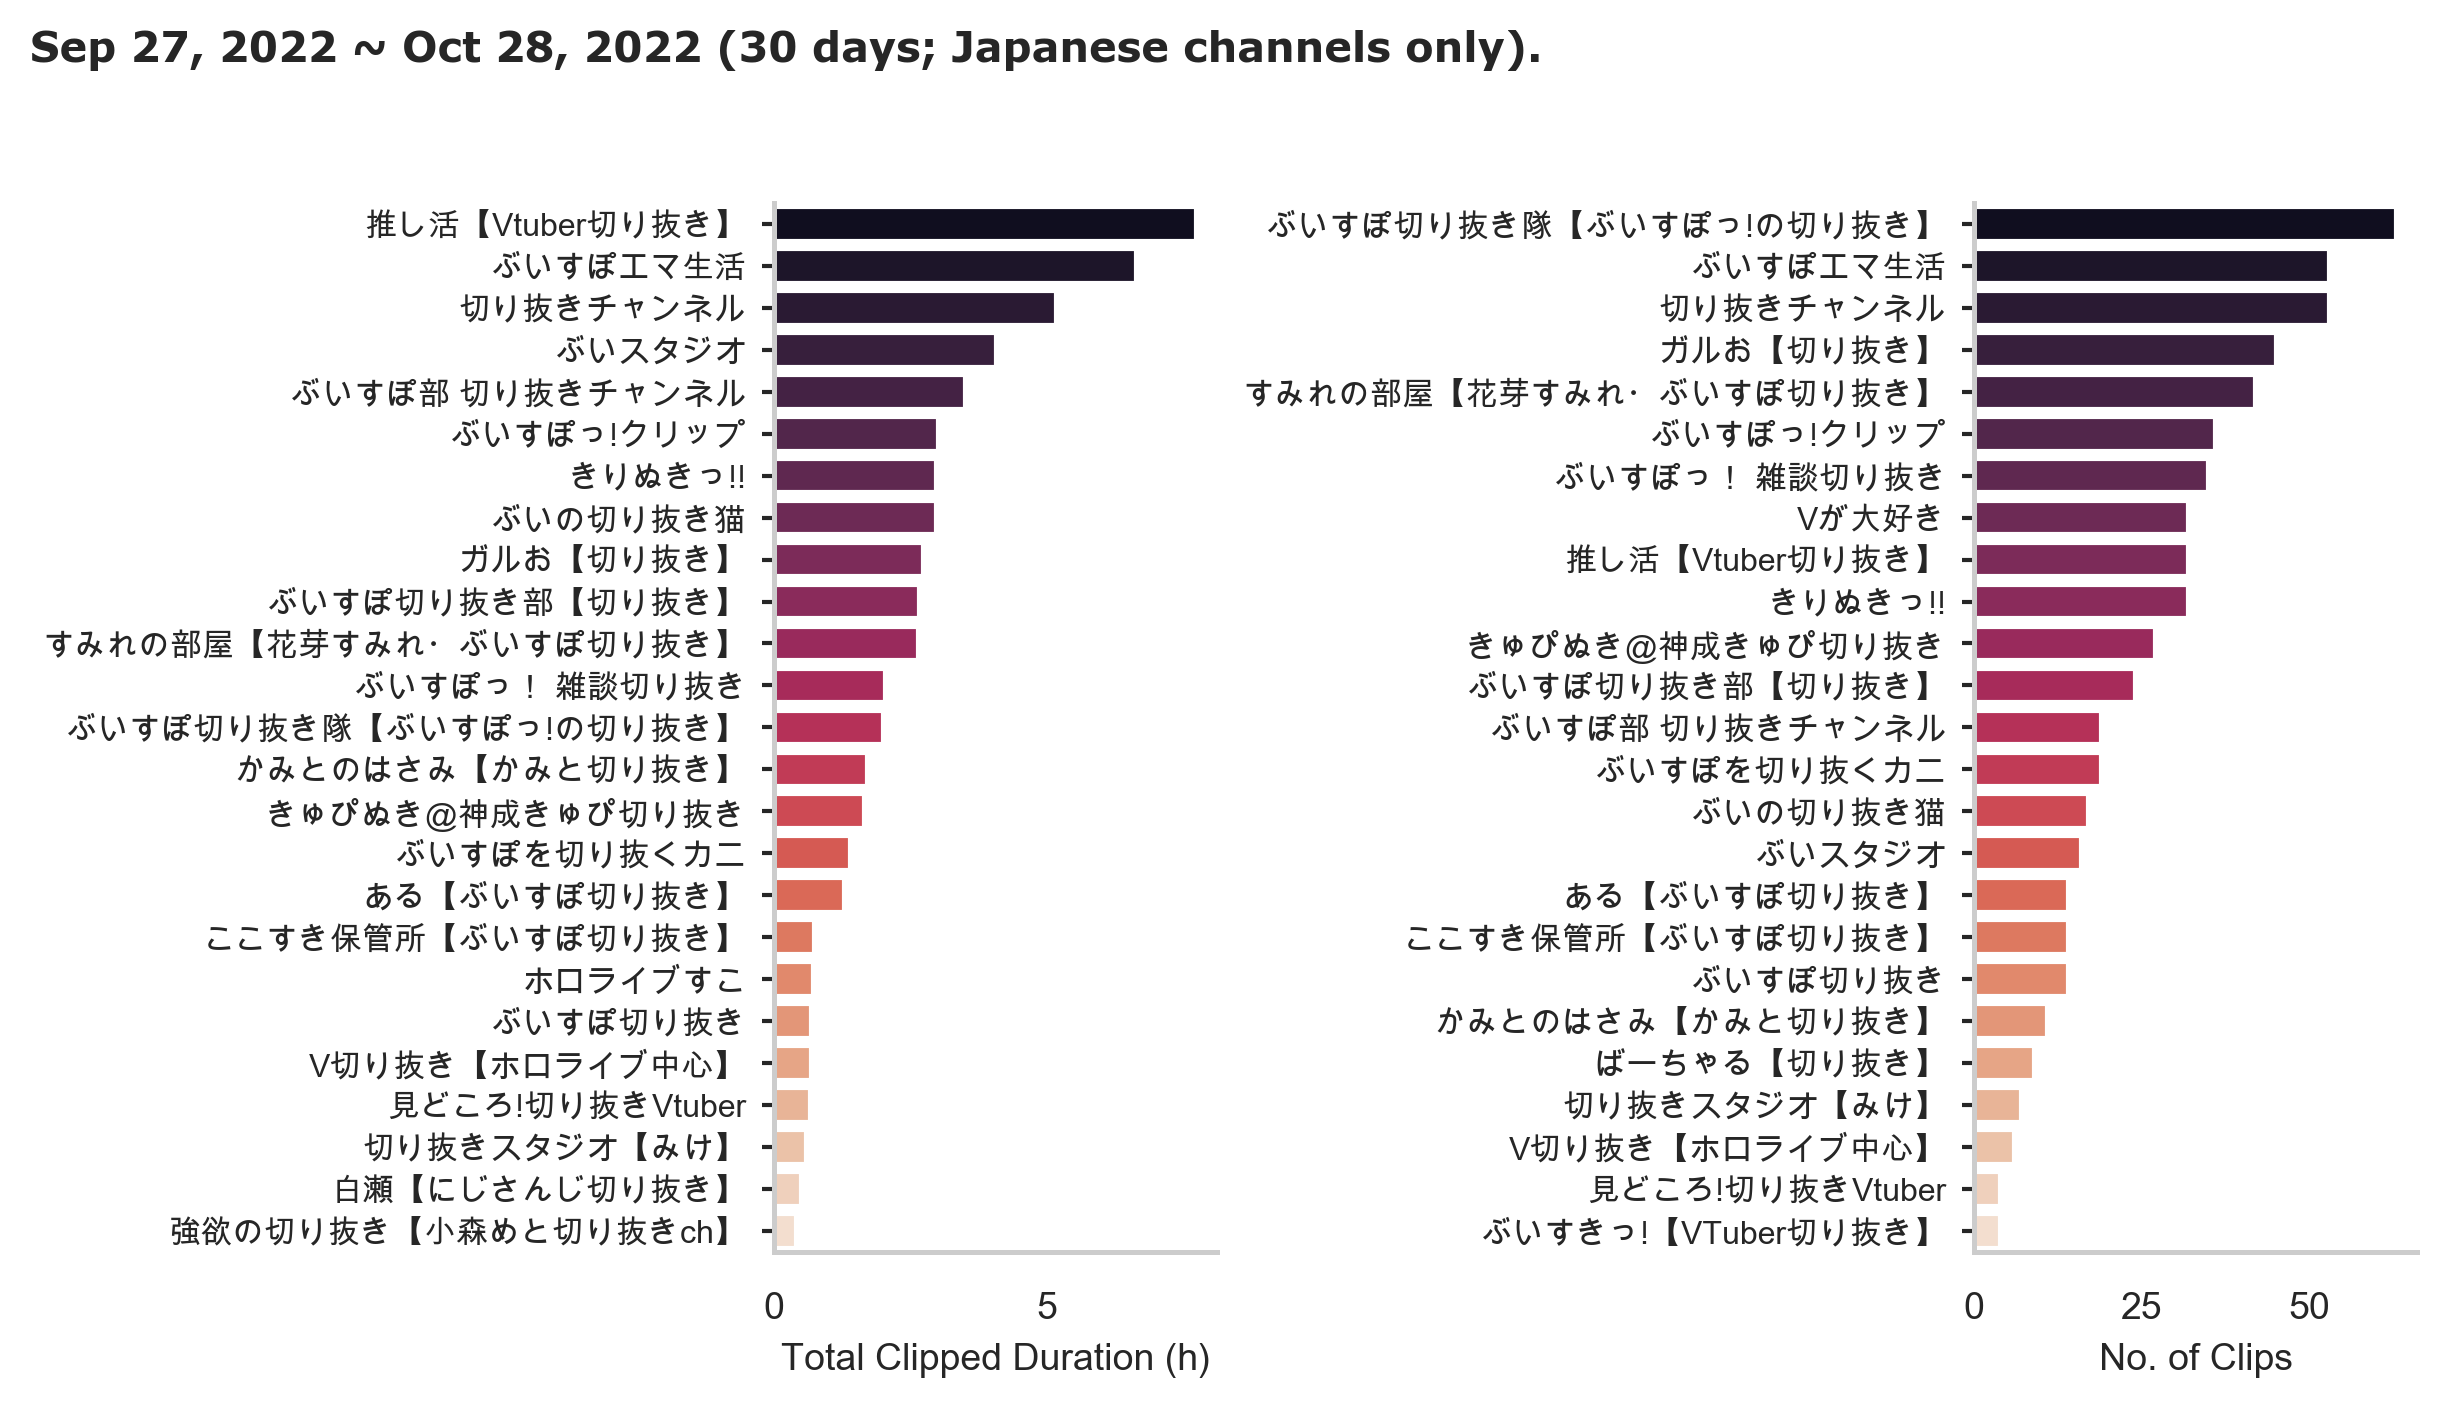

In [19]:
df_ch = clips['JP'].loc[clips['JP'].Date > ts, ['Channel', 'Duration']].\
    groupby('Channel').\
    agg(['sum', 'count'])

df_ch.iloc[:,0] /= 3600

fig, _ = plot_top25_hbars(
    df_ch, 
    unit='h',
    palette='rocket',
    names_to_style=None,
    style_kwargs=dict(),
    title=title_oct[:-1] + "; Japanese channels only).",
)

savefig(fig, 'top25_total-hours-count_30d_JP')

### Stratify by time

### Normality of clip duration (ge or le 10 min)

In [20]:
QQ_PTILES = np.linspace(0, 100, 51)
QQ_NORMAL = np.random.normal(0, 1, 400)
QQ_NORMAL_PTILES = np.percentile(QQ_NORMAL, QQ_PTILES)

def qq_plot(
    ax: plt.Axes, 
    df: pd.Series, 
    percs=QQ_PTILES, 
    norm_vals=QQ_NORMAL_PTILES, 
    norm_data=QQ_NORMAL, 
    draw_ref=True,
    **kwargs) -> np.ndarray:
    
    y_vals = np.percentile(df, percs)
    ax.plot(norm_vals, y_vals, **kwargs)

    if draw_ref: 
        ax.plot(
            np.linspace(norm_vals.min(), norm_vals.max()),
            np.linspace(y_vals.min(), y_vals.max()),
            c='k', ls='--', zorder=0, lw=1.)

    return ax 

def plot_lang_QQ(
    full_data=data, 
    figsize=(4,3), 
    norm_ptiles=QQ_NORMAL_PTILES, 
    lang_dict: dict[str, pd.DataFrame]=clips, 
    clrs=colors, 
    langs=langs, 
    fig_ax: tuple[plt.Figure, plt.Axes]=None,) -> tuple[plt.Figure, plt.Axes]:

    if fig_ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig, ax = fig_ax 

    add_title(fig)

    kw = dict(marker='o', ms=4, ls='none', mec='k', mew=0.5, draw_ref=False)

    for lang, clr in zip(langs, clrs):
        qq_plot(ax, lang_dict[lang]['Duration'] / 60, color=clr, label=lang, **kw)

    ax.plot(
        np.linspace(norm_ptiles.min(), norm_ptiles.max()),
        np.linspace(full_data.Duration.min(), full_data.Duration.max()) / 60,
        lw=0.8, ls='--', c='k',
        label=r"$\mathcal{N}(0,1)$"
    )
       
    sns.despine(ax=ax)
    ax.set_title("Q-Q plot of Clip Duration")
    ax.set_ylabel("minutes")
    ax.set_xlabel("normal quantile")

    ax.legend(frameon=False, markerscale=2, handlelength=0.8)
    ax.set_xlim((-3, 3))

    return fig, ax 


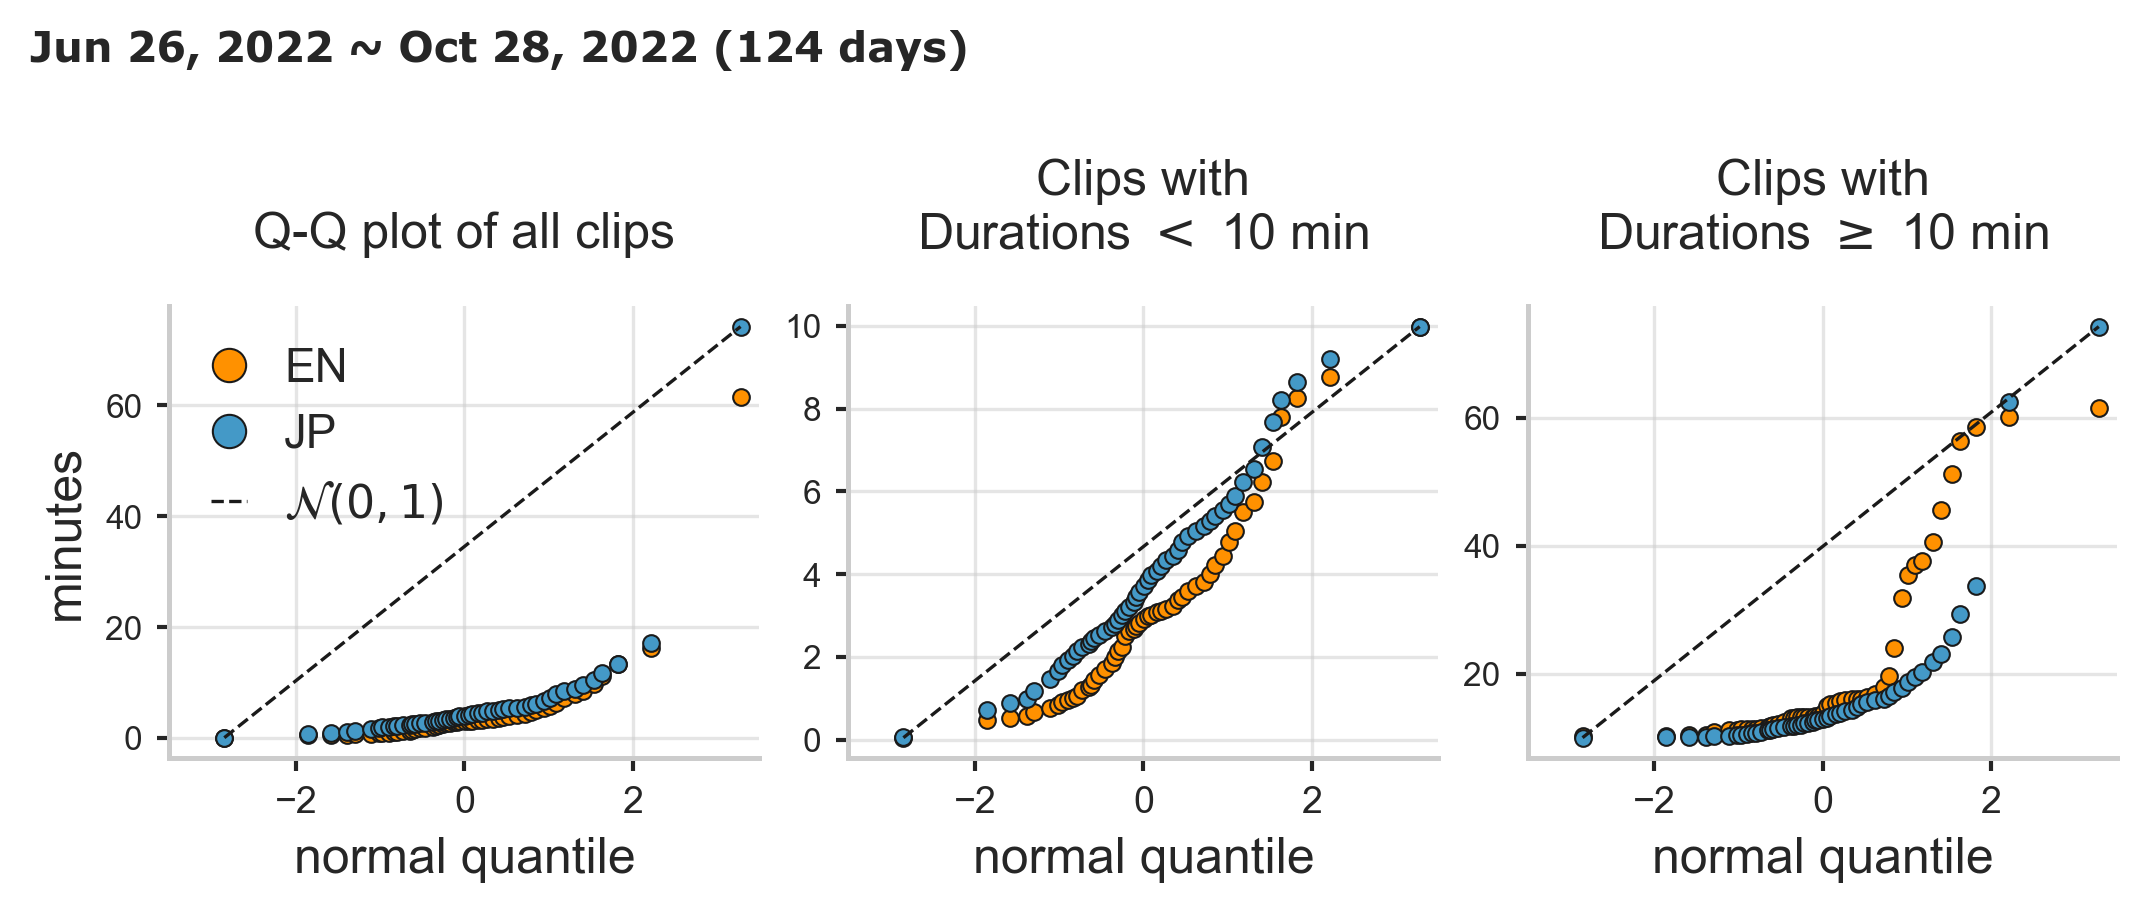

In [21]:
fig, axs = plt.subplots(1, 3, figsize=(7, 2.5))

plot_lang_QQ(fig_ax=(fig, axs[0]))

mask = data.Duration < 600 
_data = data.loc[mask, ['Channel', 'Duration']]

plot_lang_QQ(
    fig_ax = (fig, axs[1]),
    full_data=_data, 
    lang_dict=get_EN_JP_data_dict(
        get_EN_JP_clips(_data, clippers['EN']),
        langs
    )
)

_data = data.loc[~mask, ['Channel', 'Duration']]
plot_lang_QQ(
    fig_ax = (fig, axs[2]),
    full_data = _data,
    lang_dict = get_EN_JP_data_dict(
        get_EN_JP_clips(_data, clippers['EN']),
        langs
    )
)

axs[0].set_title("Q-Q plot of all clips")
axs[1].set_title("Clips with\nDurations $<$ 10 min")
axs[2].set_title("Clips with\nDurations $\geq$ 10 min")

for i in range(3):
    if i > 0:
        axs[i].get_legend().remove()
        axs[i].set_ylabel(None)
    
    axs[i].grid(True, axis='both', which='major', zorder=0, alpha=0.5, lw=0.8)
    axs[i].tick_params(axis='both', length=3, width=1, left=True, bottom=True)
    axs[i].set_xlim((-3.5, 3.5))

savefig(fig, "QQ_JP+EN_sep-by-10min")

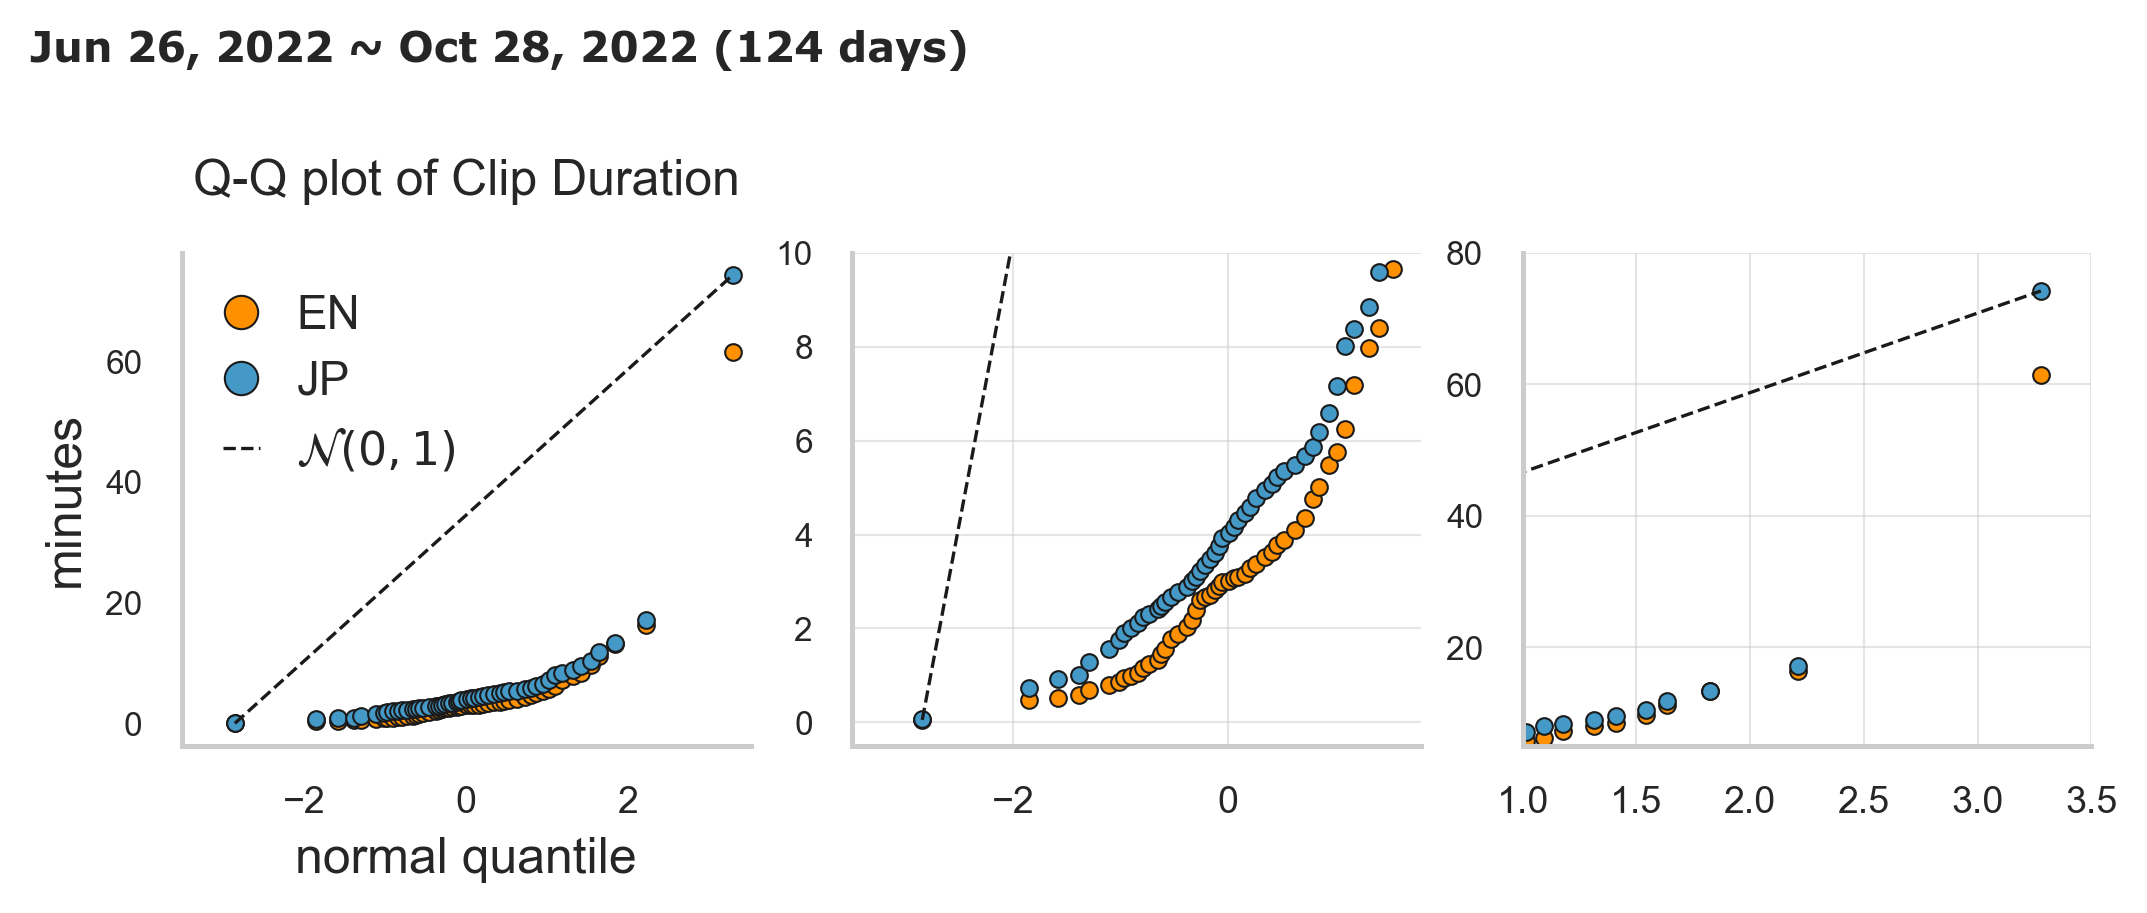

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(7, 2.5))
plot_lang_QQ(fig_ax=(fig, axs[0]))

lines = [line.get_data() for line in axs[0].get_lines()]
for i in range(1, 3):
    for j in range(3):
        x, y = lines[j] 
        
        axs[i].plot(
            x, y,
            color=colors[j] if j < 2 else 'k',
            ls='none' if j < 2 else '--', 
            marker='o' if j < 2 else None, 
            ms=4, mec='k', mew=0.5,
            lw=0.8,
        )
    
    sns.despine(ax=axs[i])
    axs[i].grid(True, axis='both', lw=0.5, alpha=0.5, zorder=0)

axs[0].set_xlim((-3.5, 3.5))
axs[1].set_ylim((-0.5, 10))
axs[1].set_xlim((-3.5, 1.8))
axs[2].set_ylim((5, 80))
axs[2].set_xlim((1, 3.5))

savefig(fig, "QQ_JP+EN_zoom")

### Stats per day

NameError: name 'y_monthly' is not defined

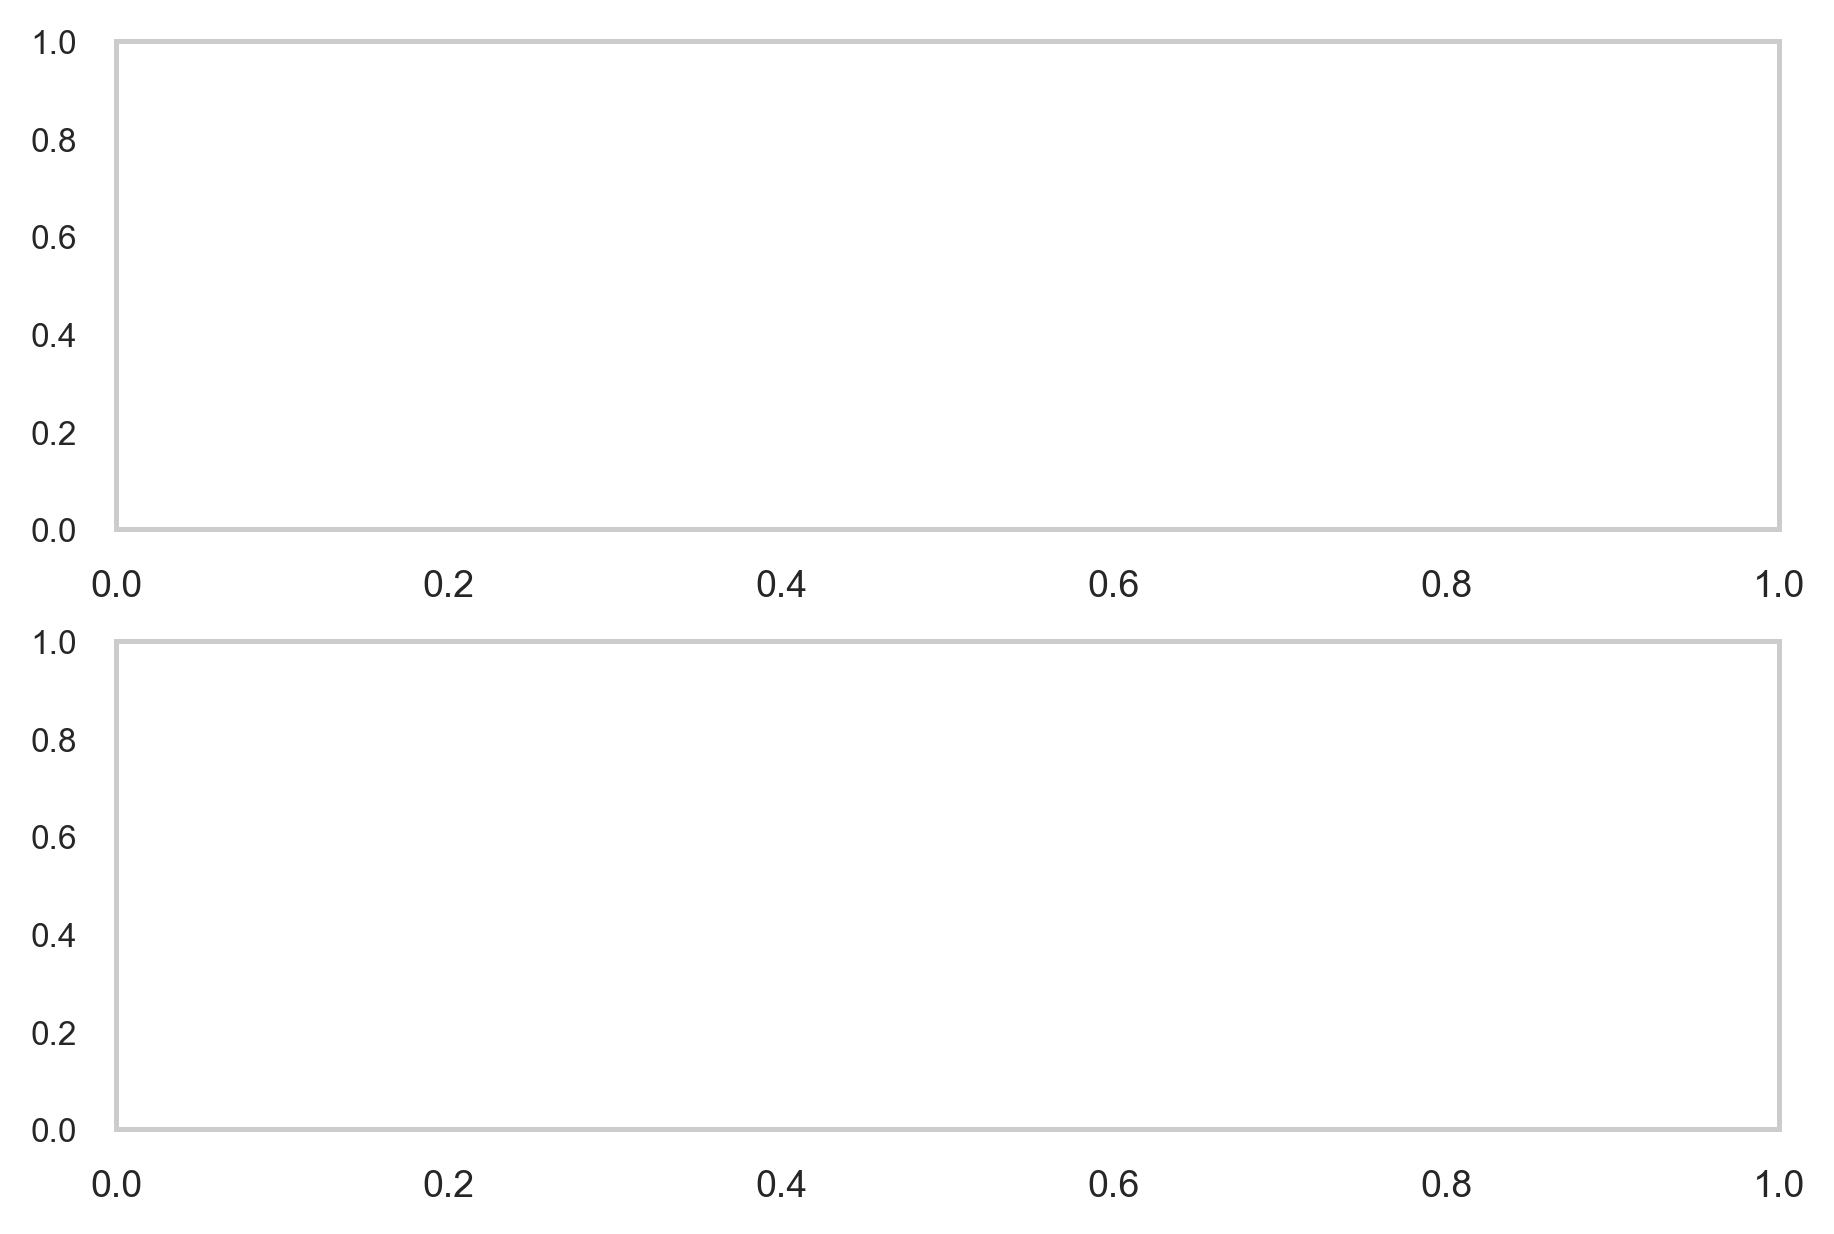

In [23]:
_, ax = plt.subplots(2, 1, figsize=(6, 4))

y_daily = pd.concat([
    data['Duration']/60,
    data['Date']
], axis=1)

y_daily = y_daily.groupby(
        [y_monthly['Language'], DT_PROPS.day_of_year]
    ).median().sort_index()

ax[0].plot(y_daily.loc(axis=0)['EN', :].droplevel(0, axis=0), color=colors[0])
ax[0].plot(y_daily.loc(axis=0)['JP', :].droplevel(0, axis=0), color=colors[1])

y_daily = pd.concat([
    data['Duration']/60,
    data['Date']
], axis=1)

y_daily = y_daily.groupby(
        [y_monthly['Language'], DT_PROPS.day_of_year]
    ).mean().sort_index()

ax[1].plot(y_daily.loc(axis=0)['EN', :].droplevel(0, axis=0), color=colors[0])
ax[1].plot(y_daily.loc(axis=0)['JP', :].droplevel(0, axis=0), color=colors[1])

ax[0].set_title('Mean and Median duration of clips from EN and JP channels')
ax[0].set_ylabel("Mean")
ax[1].set_ylabel("Median")

Some interesting observations,

- The JP and EN lines seem to track each other quite closely, but
- the JP line is consistently higher than the EN line 

Text(0, 0.5, 'Median')

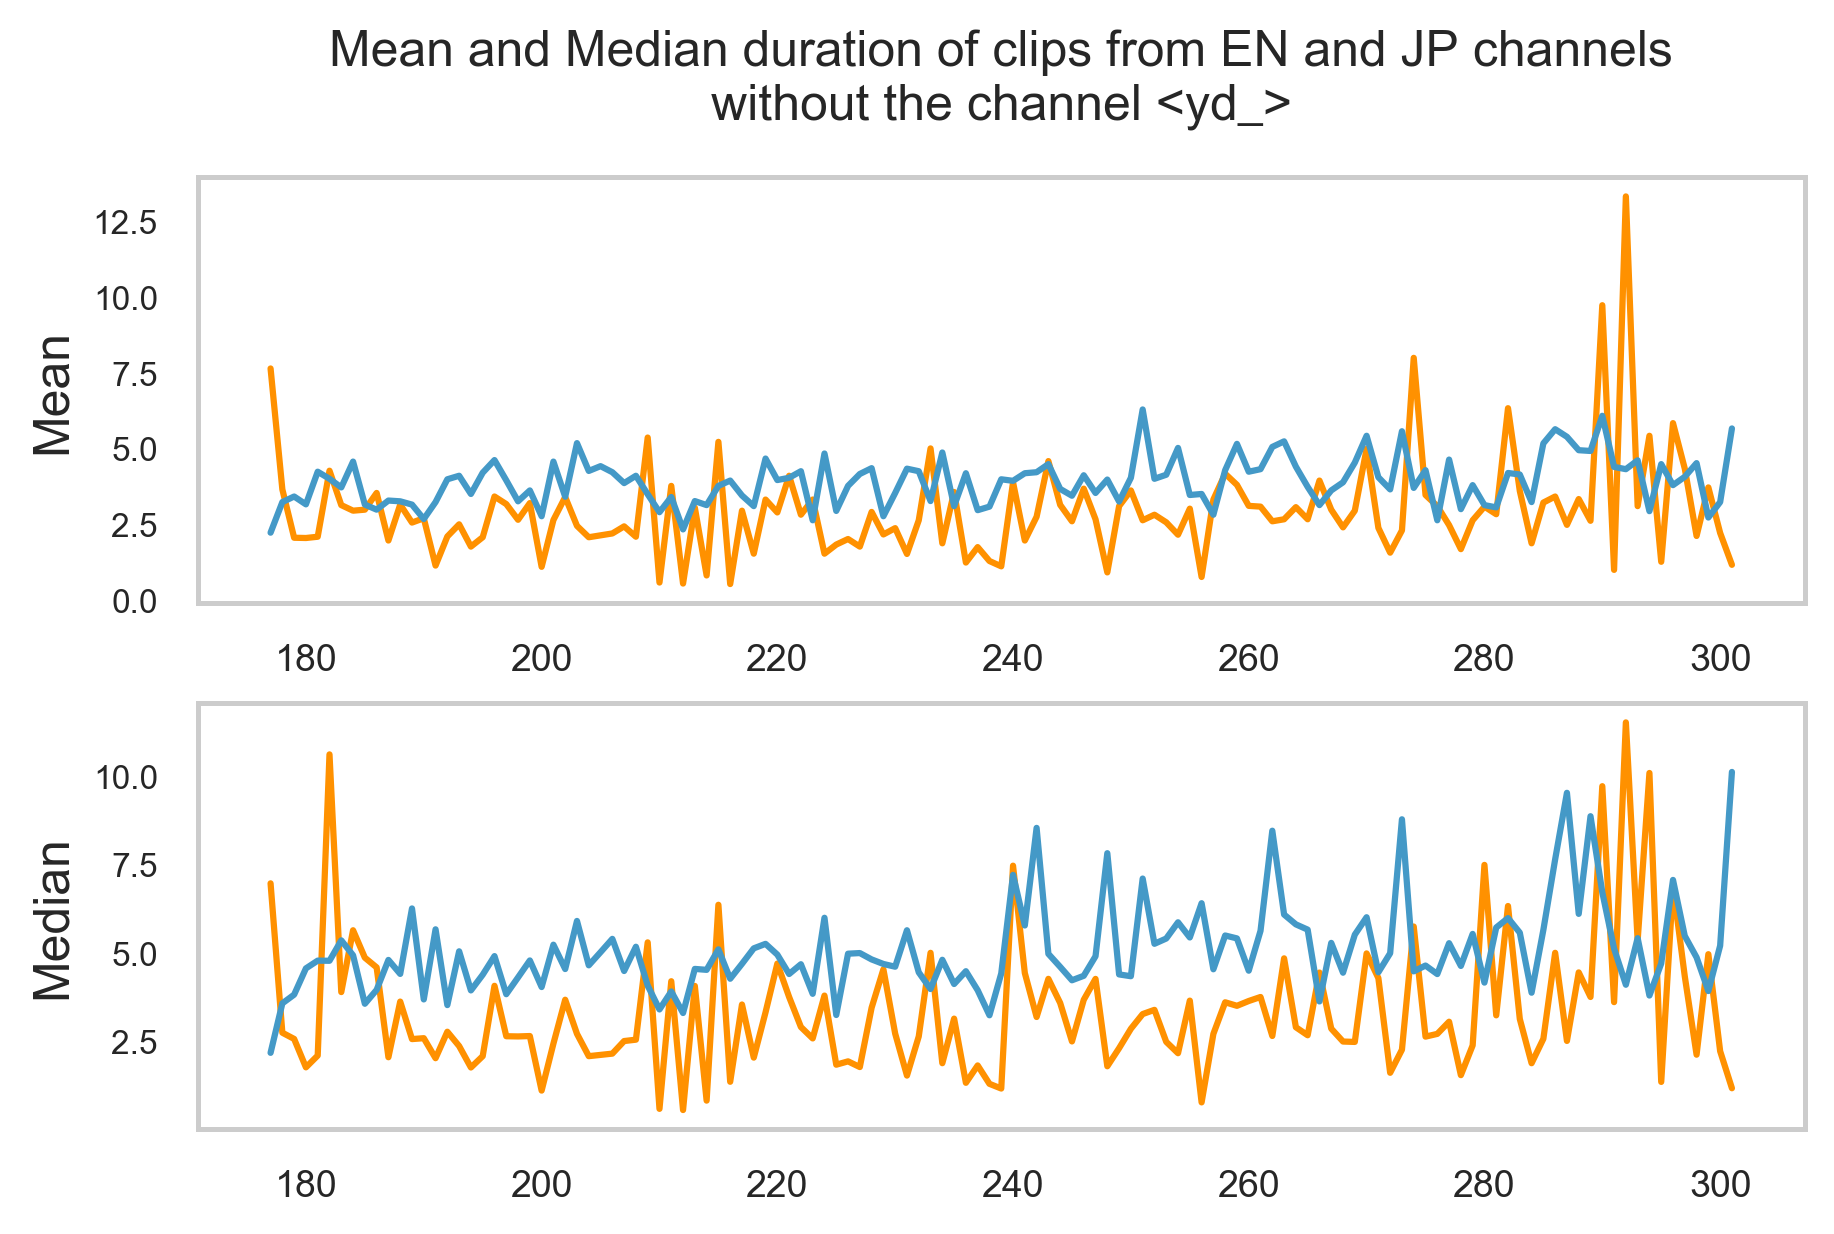

In [ ]:
data_noMe = data.loc[data['Channel'] != 'yd_', :]
y_daily = pd.concat([
    data_noMe['Duration']/60,
    data_noMe['Date']
], axis=1)

y_daily = y_daily.groupby(
        [y_monthly['Language'], DT_PROPS.day_of_year]
    ).median().sort_index()

_, ax = plt.subplots(2, 1, figsize=(6, 4))

ax[0].plot(y_daily.loc(axis=0)['EN', :].droplevel(0, axis=0), color=colors[0])
ax[0].plot(y_daily.loc(axis=0)['JP', :].droplevel(0, axis=0), color=colors[1])

y_daily = pd.concat([
    data_noMe['Duration']/60,
    data_noMe['Date']
], axis=1)

y_daily = y_daily.groupby(
        [y_monthly['Language'], DT_PROPS.day_of_year]
    ).mean().sort_index()

ax[1].plot(y_daily.loc(axis=0)['EN', :].droplevel(0, axis=0), color=colors[0])
ax[1].plot(y_daily.loc(axis=0)['JP', :].droplevel(0, axis=0), color=colors[1])

ax[0].set_title('Mean and Median duration of clips from EN and JP channels\nwithout the channel <yd_>')
ax[0].set_ylabel("Mean")
ax[1].set_ylabel("Median")

### Count and duration stats by month

In [27]:
df_monthly = data['Duration'].groupby([DT_PROPS.month, data['Channel'].\
    isin(clippers['EN'])]).\
    agg(['sum', 'count']).\
    rename({False : 'JP', True : 'EN'}, axis=0, level=1).\
    rename_axis(('Month', 'Language'), axis=0).\
    loc(axis=0)[range(7, 11), :]

df_monthly

sum  count
Month Language               
7     JP        201143    731
      EN         33898    131
8     JP        230171    790
      EN         29498    126
9     JP        228790    691
      EN         31451    136
10    JP        198837    594
      EN         38477    118

In [28]:
data['isEN'] = data.Channel.isin(clippers['EN'])
data['MonthName'] = DT_PROPS.month_name()

In [43]:
y2 = y.iloc[:, 2:]
jp_en_ratio = pd.DataFrame(y2.iloc[::2, :].values / y2.iloc[1::2,:].values)
jp_en_ratio.columns = ['sum', 'count']
jp_en_ratio

sum     count
0  5.933772  5.580153
1  7.802936  6.269841
2  7.274490  5.080882
3  5.167685  5.033898

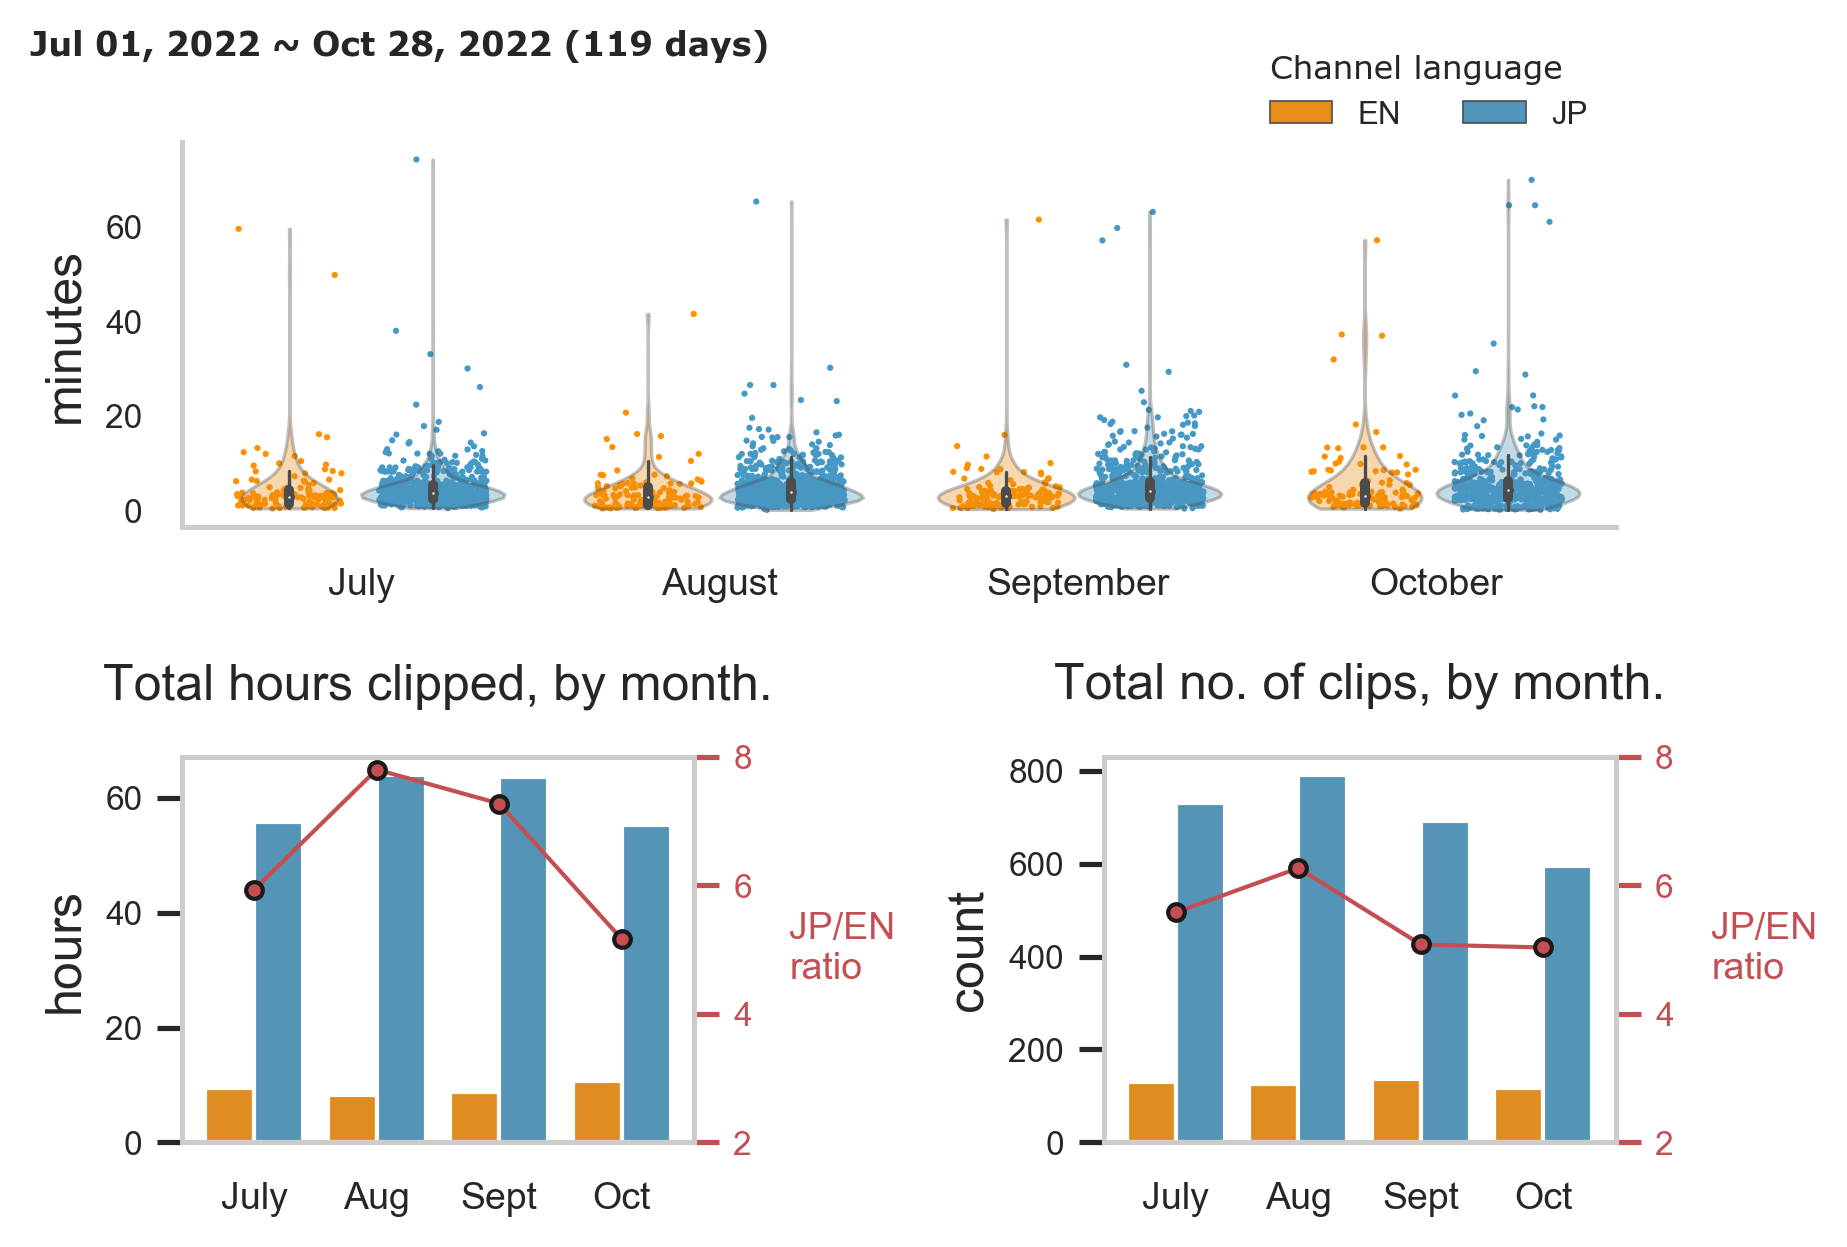

In [67]:
MONTH_NAMES = ['July', 'Aug', 'Sept', 'Oct']
y = df_monthly.reset_index()
y['sum'] /= 3600

fig = plt.figure(figsize=(6, 4))

add_title(
    fig, title=get_title(data.loc[DT_PROPS.month > 6, 'Date']),
    fontsize=8, fontweight='semibold', y=1, va='top'
)

gs = fig.add_gridspec(nrows=2, ncols=2, wspace=0.02, hspace=0.1)
axs = [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1]), fig.add_subplot(gs[0, :])]

kw = dict(hue='Language', hue_order=['EN', 'JP'], palette=colors, data=y, x=y.Month)

sns.barplot(y=y['sum'], ax=axs[0], **kw)
sns.barplot(y=y['count'], ax=axs[1], **kw)

kw = dict(lw=1, c='r', mfc='r', marker='o', mec='k', mew=1, ms=4)
axs0_2 = axs[0].twinx()
axs0_2.plot(jp_en_ratio.iloc[:,0], **kw)
axs0_2.set_ylim((2, 8))
axs0_2.tick_params(colors='r', labelcolor='r')

twin_label_kw = dict(color='r', fontsize=9, rotation=0, labelpad=9, y=0.6, ha='left')
axs0_2.set_ylabel("JP/EN\nratio", **twin_label_kw)

axs1_2 = axs[1].twinx()
axs1_2.plot(jp_en_ratio.iloc[:,1], **kw)
axs1_2.set_ylim((2, 8))
axs1_2.tick_params(colors='r', labelcolor='r')
axs1_2.set_ylabel("JP/EN\nratio", **twin_label_kw)

kw = dict(
    data=data, x='MonthName', 
    y=data.Duration/60, hue='isEN', 
    hue_order=[True, False], 
    palette=colors, orient='v',
    ax=axs[2]
)

sns.violinplot(cut=0, scale='area', dodge=True, saturation=0.8, linewidth=0.8, facecolor='w', **kw)

for violin in axs[2].collections[::2]:
    violin.set_alpha(0.35)

sns.stripplot(size=1.5, dodge=True, edgecolor='gray', jitter=0.3, zorder=0, **kw)

axs[2].set_xlim((0.5, 4.5))

axs[0].set_title('Total hours clipped, by month.')
axs[1].set_title('Total no. of clips, by month.')
axs[0].set_ylabel('hours')
axs[2].set_ylabel('minutes')

h, l = axs[2].get_legend_handles_labels()
leg = axs[2].legend(
    h, langs, 
    loc='upper right', 
    bbox_to_anchor=[1, 1.3], 
    fontsize=7.5, 
    frameon=False, 
    title='Channel language', 
    markerscale=0.5, 
    ncol=2,
    title_fontproperties=dict(size=7.8, weight='regular', family='Verdana')
)

leg._legend_box.align = "left"

for i in range(3):
    if i < 2:
        axs[i].set_xticklabels(MONTH_NAMES)
        axs[i].get_legend().remove()

    axs[i].set_xlabel(None)
    sns.despine(ax=axs[i])

savefig(fig, "total-hours-count_by-month_EN+JP")

### Number of unique channels per month

In [ ]:
df_monthly = data.set_index(['isEN', 'MonthName'])
df_monthly.head()

Date  Duration          Channel
isEN  MonthName                                               
True  June      2022-06-26 16:36:00       594      Rezado-subs
      June      2022-06-26 16:40:00       458   Ush Order Subs
False June      2022-06-26 19:30:00       143  ぶいすぽ切り抜き部【切り抜き】
      June      2022-06-26 19:31:00       124      ホロライブ切り抜き戦士
      June      2022-06-26 19:53:00       180  推し活【Vtuber切り抜き】

In [ ]:
unique_chs_monthly: dict[str, dict[str, list]] = {} 

for i in range(2):
    old = None
    udic: dict[str, list[str]] = {} 
    df_i = df_monthly.loc(axis=0)[i, :].droplevel(0, axis=0)

    for month in data['MonthName'].unique():
        
        if old is None:
            old = df_i.loc[month, 'Channel'].unique()
            udic[month] = old 
            continue 

        new = df_i.loc[month, 'Channel'].unique()
        udic[month] = new[~np.isin(new, old)]
        old = np.union1d(old, new)

    unique_chs_monthly[langs[abs(i-1)]] = udic 

In [ ]:
new_clippers_monthly = pd.DataFrame.from_dict(unique_chs_monthly)
# .apply(lambda s: s.apply(lambda x: len(x)))
new_clippers_monthly

JP  \
June       [ぶいすぽ切り抜き部【切り抜き】, ホロライブ切り抜き戦士, 推し活【Vtuber切り抜き】...   
July       [白瀬【にじさんじ切り抜き】, すぽすぴ【切り抜き】, かみとのはさみ【かみと切り抜き】, ...   
August     [【 Vtuber Clips 】んまった, しおぽぐ@手描き, ば一ちゃるこれくしょん, ...   
September               [切り抜きsan, ホロライブ切り抜きSAI, ホロライブこれくしょん]   
October    [V切り抜き【ホロライブ中心】, ぶいパシャ【vtuber切り抜きｃｈ】, 零蘭, ホロライ...   

                                                          EN  
June       [Rezado-subs, Ush Order Subs, R Subs, X-ray VS...  
July       [Zoro Zaki [ Clypto ], Sobbers Clipper, yd_, k...  
August     [Vtuber resistance-Eng sub, V LOVE CLIP Englis...  
September  [Slice of Vspo, Sakura [Vtuber切り抜き翻訳], Yuri Sh...  
October     [Yuri Shizu -Sub Channel-, Ene Chan, ShiroiRika]

In [ ]:
new_clippers_monthly.at['September', 'EN']

array(['Slice of Vspo', 'Sakura [Vtuber切り抜き翻訳]', 'Yuri Shizu', 'Holo EYE',
       'Oboretai Writing ch.', 'IonXepH'], dtype=object)

In [96]:
cnt_en_jp = data.loc[:, ['Channel', 'isEN', 'Duration']].\
    groupby(['Channel', 'isEN']).\
    count().\
    reset_index(level=1).\
    replace({True : 'EN', False : 'JP'})

cnt_en_jp.columns = ['isEN', 'Count']
cnt_en_jp.head()

isEN  Count
Channel                               
Cutting Samurai              JP      1
Daruma English Clip          EN      2
Ene Chan                     EN      1
Galaxy VTuber Translations   EN      4
Hasami Ch.はさみちゃん             JP      1

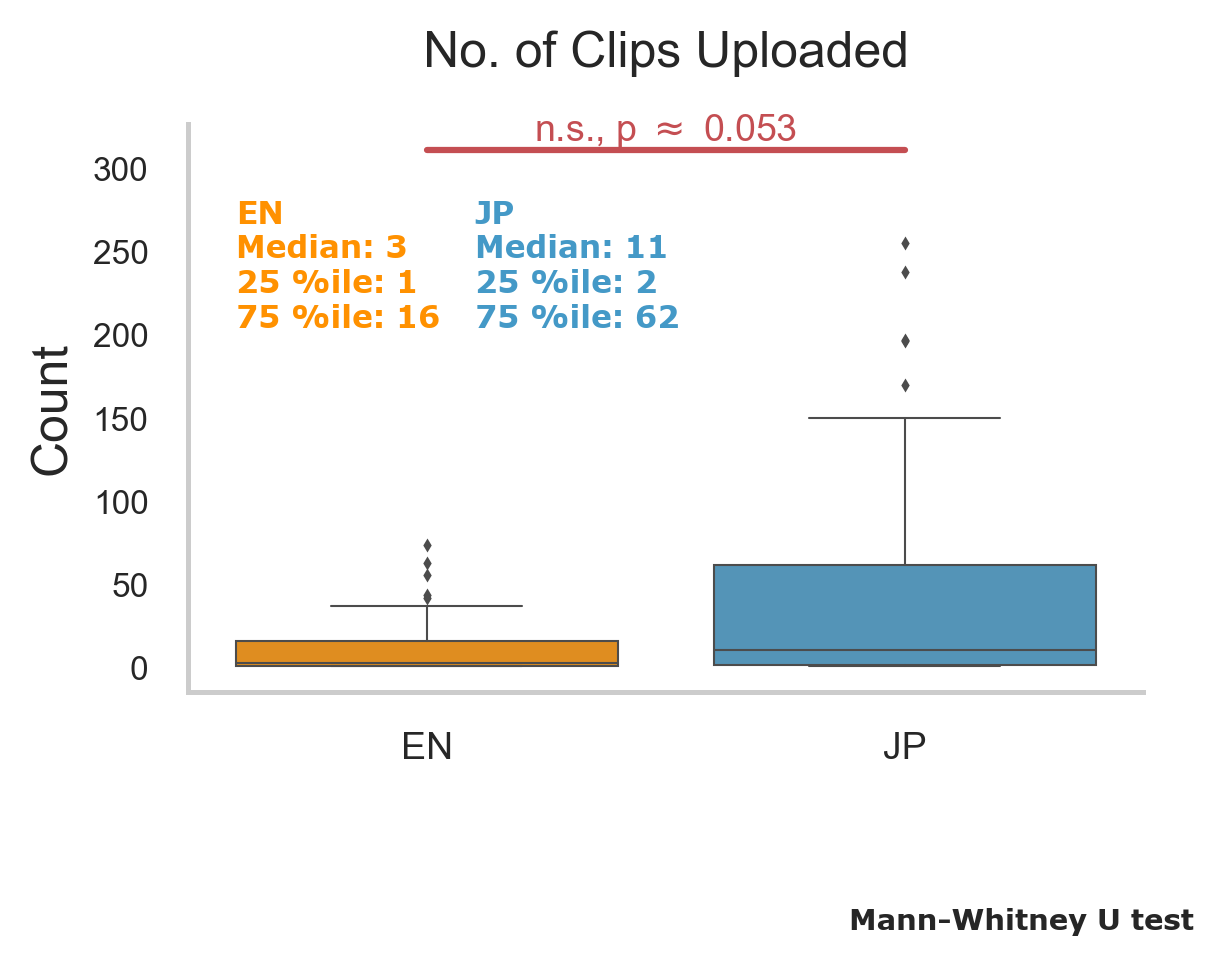

In [146]:
fig, ax = plt.subplots(figsize=(4, 3))

mask = cnt_en_jp['isEN'] == 'EN'
_, pval = mannwhitneyu(
    cnt_en_jp.loc[mask, 'Count'], 
    cnt_en_jp.loc[~mask, 'Count']
)

sns.boxplot(data=cnt_en_jp, x='isEN', y='Count', ax=ax, fliersize=1, palette=colors, order=langs, linewidth=0.5)
draw_pval(ax, range(2), cnt_en_jp.Count.max(), pval, frac=0.2)

ax.set_ylabel('Count')
ax.set_title('No. of Clips Uploaded')
ax.set_xlabel(None)

sns.despine(ax=ax)

_get_statleglab = lambda X: f"Median: {np.median(X):.0f}\n25 %ile: {_quant25(X):.0f}\n75 %ile: {_quant75(X):.0f}"

annots = [
    "EN\n" + _get_statleglab(cnt_en_jp.loc[mask, 'Count']), 
    "JP\n" + _get_statleglab(cnt_en_jp.loc[~mask, 'Count'])
]
    
kw = dict(fontfamily='Verdana', fontweight='semibold', fontsize=7.5, ha='left', va='center', transform=ax.transAxes)
ax.text(0.05, 0.75, annots[0], color=colors[0], **kw)
ax.text(0.3, 0.75, annots[1], color=colors[1], **kw)

ax.text(0.98, 0.01, "Mann-Whitney U test", 
    fontsize=7, fontweight='bold', 
    fontfamily='Verdana', ha='right', va='top', 
    transform=fig.transFigure
)

savefig(fig, "total-no-clips_byLang_stats")